## **Rapport d'exploration, de data visualisation et de pre processing des données**

## ***Pré Requis***

In [ ]:
#install wordcloud et install nltk pour import du stopwords
##!pip install wordcloud
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

True

### *Import des fichiers*

In [ ]:
# Open a session: initialize a few practical constants, mount share drive
from google.colab import drive
import os.path

DRIVE_PATH = "/content/drive/Shareddrives/ds_nov22_cnt_rakuten"
CSV_FILE_DIR = os.path.join(DRIVE_PATH, "train_test/csv_files")
IMG_DIR = os.path.join(DRIVE_PATH, "train_test/images")
IMG_TRAIN_DIR = os.path.join(IMG_DIR, "image_train")

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Load train CSV files
# Note: compared to the original X_train file, X_train_with_img_path.csv contains an extra column "image_path"
# That column gives the full path to the image of each product.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import random
import pickle
import os
X_train = pd.read_csv(os.path.join(CSV_FILE_DIR, "X_train_with_img_path.csv"), index_col=0)
y_train = pd.read_csv(os.path.join(CSV_FILE_DIR, "Y_train_CVw08PX.csv"), index_col=0)

## fusion des deux fichiers
X_y_train = X_train.join(y_train)

# "Copie de sauvegarde" pour pouvoir restaurer X_y_train rapidement en cas d'erreur dans la suite
X_y_train_brut = X_y_train

### *Exploration des données*

In [ ]:
## affichage des informations
X_y_train.info()
## des valeurs manquent sur le champs "description"

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84916 entries, 0 to 84915
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   designation  84916 non-null  object
 1   description  55116 non-null  object
 2   productid    84916 non-null  int64 
 3   imageid      84916 non-null  int64 
 4   image_path   84916 non-null  object
 5   prdtypecode  84916 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 6.6+ MB


In [ ]:
## vérification du nombre de valeurs NaN
X_y_train.isna().sum()
## plus de 29 000 lignes avec description manquante soit près de 35% du jeu de données

designation        0
description    29800
productid          0
imageid            0
image_path         0
prdtypecode        0
dtype: int64

In [ ]:
## comptage des types produits
X_y_train["prdtypecode"].value_counts()

2583    10209
1560     5073
1300     5045
2060     4993
2522     4989
1280     4870
2403     4774
2280     4760
1920     4303
1160     3953
1320     3241
10       3116
2705     2761
1140     2671
2582     2589
40       2508
2585     2496
1302     2491
1281     2070
50       1681
2462     1421
2905      872
60        832
2220      824
1301      807
1940      803
1180      764
Name: prdtypecode, dtype: int64

### *Phase de Pre Processing*

**Labelisation des 'PrdTypeCode' :** cette étape a été réalisée dans un second temps après quelques 1eres analyses graphiques (word cloud, panel d'images) qui ont permis de constater que pour une meilleure lisibilité, une labelisation des prdtypecode était nécessaire.


In [ ]:
# Labelisation des PrdTypeCode avec l'ajout d'une nouvelle colonne
X_y_train['Labels'] = X_y_train['prdtypecode']
X_y_train['Labels'] = X_y_train['Labels'].astype(str)
X_y_train['Labels'].replace({'2583':'Accessoires piscine et spa','1560':'Mobilier intérieur','1300':
'Modélisme','2060':'Eclairage et décoration','2522':'Papeterie','1280':'Jouets','2403':'Magazines et revues','2280':'Archives journaux et presse',
'1920':'Linge de maison','1160':'Cartes à échanger','1320':'Puericulture', '10':'Livres occasions','2705':'Livres',
'1140':'Figurines','2582':'Décorations ext. et accessoires','40':'jeux videos','2585':'Bricolage, jardinage','1302':'Loisirs extérieur',
'1281':'Jeux de société','50':'Loisirs intérieur','2462':'Acc. jeux vidéos, Consoles et jeu','2905':'Jeux en téléchargement',
'60':'Console de jeu vintage','2220':'Animalerie','1301':'Accessoires enfants','1940':'Alimentation','1180':'Jeux de rôle et jeux de figurines'}, inplace=True)


**Phase de nettoyage des données :** retrait des données manquantes, fusion des champs descriptions et designations, retrait des caractères spécifiques et des balises html, traduction des textes dans une seule et même langue.

In [ ]:
#Conservation d'une copie de X_y_train avant modification pour graphique de distribution des classes et des NAs
X_y_train_origine = X_y_train

# remplacement des NaN par des champs à vide
X_y_train = X_y_train.fillna('')

# conversion du Dataframe en string
X_y_train=X_y_train.astype("str")

# fusion des champs description et designation
# On ajoute dans une nouvelle colonne la description et la designation de manière fusionnée
X_y_train["design_describe"] = [(x + " " + y).strip() for x,y in zip(X_y_train["designation"],X_y_train["description"])]

# Nettoyage des caractères spéciaux/accents/etc dans design_describe :
# peut être utile pour la normalisation et le traitement des données textuelles dans les modèles d'apprentissage automatique.
X_y_train["design_describe"] = X_y_train["design_describe"].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

# HTML : retrait des balises (mais conservation du texte qu'elles contiennent) avec BeautifulSoup
#      + décodage des chaînes type "&XXX;" en caractères avec la librairie html
import html
from bs4 import BeautifulSoup
X_y_train["design_describe"] = X_y_train["design_describe"].apply(
    lambda text: html.unescape(BeautifulSoup(text, 'html.parser').get_text())
)

# Une inspection avec le pattern d'expression régulière "<[a-z][^>]*$" montre que quelques balises *incorrectes* persistent
# Il s'agit de balises "br", "strong", "span", "img" et "a" bien initialisées avec un "<", mais soit sans ">", soit avec un "<" à la place.
# Traitons-les une fois pour toute en les remplaçant par des espaces.
import re
X_y_train["design_describe"] = X_y_train["design_describe"].apply(lambda txt: re.sub("<(br<|strong<|br|strong|span|img|a)", " ", txt, flags=re.IGNORECASE))

# affichage des 1eres lignes
display(X_y_train.head())

# vérification qu'il n'y ait plus de valeurs manquantes
display(X_y_train.isna().sum())


<ipython-input-14-c06ae2f5fb85>:23: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  lambda text: html.unescape(BeautifulSoup(text, 'html.parser').get_text())


designation  \
0  Olivia: Personalisiertes Notizbuch / 150 Seite...   
1  Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...   
2  Grand Stylet Ergonomique Bleu Gamepad Nintendo...   
3  Peluche Donald - Europe - Disneyland 2000 (Mar...   
4                               La Guerre Des Tuques   

                                         description   productid     imageid  \
0                                                     3804725264  1263597046   
1                                                      436067568  1008141237   
2  PILOT STYLE Touch Pen de marque Speedlink est ...   201115110   938777978   
3                                                       50418756   457047496   
4  Luc a des id&eacute;es de grandeur. Il veut or...   278535884  1077757786   

                                          image_path prdtypecode  \
0  /content/drive/Shareddrives/ds_nov22_cnt_rakut...          10   
1  /content/drive/Shareddrives/ds_nov22_cnt_rakut...        2280   
2  /content/drive/Shareddrives/ds_nov22_cnt_rakut...          50   
3  /content/drive/Shareddrives/ds_nov22_cnt_rakut...        1280   
4  /content/drive/Shareddrives/ds_nov22_cnt_rakut...        2705   

                        Labels  \
0             Livres occasions   
1  Archives journaux et presse   
2            Loisirs intérieur   
3                       Jouets   
4                       Livres   

                                     design_describe  
0  Olivia: Personalisiertes Notizbuch / 150 Seite...  
1  Journal Des Arts (Le) N 133 Du 28/09/2001 - L'...  
2  Grand Stylet Ergonomique Bleu Gamepad Nintendo...  
3  Peluche Donald - Europe - Disneyland 2000 (Mar...  
4  La Guerre Des Tuques Luc a des idées de grande...

designation        0
description        0
productid          0
imageid            0
image_path         0
prdtypecode        0
Labels             0
design_describe    0
dtype: int64

### *Phase de Traduction*

In [ ]:
#Installation des traducteurs
!pip install googletrans
!pip install deep-translator
!pip install langdetect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 KB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 KB 5.7 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-3.0.0-py3-none-any.whl size=15735 sha256=2ba3240b207b111e54fb89e1c5f329f1b37d4aabdd3dbc4a0d2129f72c541354
  Stored in directory: /root/.cache/pip/wheels/27/f3/32/d4859d40071f07a5df0ab6fdc0076e78a8a786625dde2b4b2f
Successfully built googletrans
  Attempting uninstall: idna
    Found existing installation: idna 3.4
    Uninstal

In [ ]:
#Lancement de la traduction
import pandas as pd
from deep_translator import GoogleTranslator
from langdetect import detect
import time

def translate_batch(dataframe, column, start_index, batch_size):
    translated_descriptions = []

    for index in range(start_index, start_index + batch_size):
        if index >= len(dataframe):
            break

        original_text = dataframe.iloc[index][column]

        if original_text:
            translated_text = translate_text(original_text)
        else:
            translated_text = ""

        translated_descriptions.append(translated_text)

    return translated_descriptions

def split_text(text, max_length=1500):
    words = text.split(' ')
    split_texts = []
    current_text = ''

    for word in words:
        if len(current_text) + len(word) + 1 > max_length:
            split_texts.append(current_text)
            current_text = ''
        current_text += f'{word} '

    if current_text:
        split_texts.append(current_text)

    return split_texts

def translate_text(text, source='auto', target='fr'):
    detected_language = detect(text)

    if detected_language == 'fr':
        return text

    splitted_texts = split_text(text)
    translated_parts = []

    for part in splitted_texts:
        translated_text = GoogleTranslator(source=source, target=target).translate(part)
        if translated_text is None:
            translated_text = ""  # Utilisez une chaîne vide si la traduction échoue ou retourne None
        translated_parts.append(translated_text)

    return ' '.join(translated_parts)  # Retourne les parties traduites combinées

# Gestion des paquets
batch_size = 1000
# démarrage à partir de la ligne 0
start_index = 0
num_elements = 84916
num_batches = (num_elements + batch_size - 1) // batch_size

#création d'un dataframe pour stocker les traductions
translated_df = pd.DataFrame(columns=["translated_description"])
start_time = time.time()

remaining_batches = num_batches - (start_index // batch_size)
if remaining_batches > 0:
    for _ in range(remaining_batches):
        translated_descriptions = translate_batch(X_y_train, "design_describe", start_index, batch_size)
        start_index += batch_size
        temp_df = pd.DataFrame(translated_descriptions, columns=["translated_description"])
        translated_df = translated_df.append(temp_df, ignore_index=True)

    end_time = time.time()

    time_per_batch = (end_time - start_time) / remaining_batches
    print(f"Temps pour un lot : {time_per_batch} secondes")

    estimated_total_time = time_per_batch * num_batches
    print(f"Temps estimé pour tous les lots : {estimated_total_time} secondes")
else:
    print("Aucun lot restant à traiter.")

#vérification des dimensions
translated_df.shape

# Sauvegarder le DataFrame pour sauvegarder toutes les traductions
translated_df.to_csv("/content/drive/Shareddrives/ds_nov22_cnt_rakuten/traduction_colonne_design_describe.csv", index=False)

<ipython-input-11-f578618815a7>:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  translated_df = translated_df.append(temp_df, ignore_index=True)
<ipython-input-11-f578618815a7>:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  translated_df = translated_df.append(temp_df, ignore_index=True)
<ipython-input-11-f578618815a7>:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  translated_df = translated_df.append(temp_df, ignore_index=True)
<ipython-input-11-f578618815a7>:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  translated_df = translated_df.append(temp_df, ignore_index=True)
<ipython-input-11-f578618815a7>:75: FutureWarning: The f

Temps pour un lot : 235.997056871302 secondes
Temps estimé pour tous les lots : 20059.74983406067 secondes


In [ ]:
#Emplacement du csv telechargé pour creer une copie locale
import os
current_working_directory = os.getcwd()
file_name = 'traduction_colonne_design_describe.csv'
file_path = os.path.join(current_working_directory, file_name)
print(f"Le fichier CSV a été stocké à l'emplacement suivant: {file_path}")

Le fichier CSV a été stocké à l'emplacement suivant: /content/traduction_colonne_design_describe.csv


In [ ]:
# import du nouveau fichier des traductions
translated_df=pd.read_csv('/content/drive/Shareddrives/ds_nov22_cnt_rakuten/traduction_colonne_design_describe.csv')
# Ajout de translated_df dans X_y_train pour créer un csv contenant toutes les données nécéssaires
X_y_train["designe_decrit"] = translated_df
# On enregistre les traductions et la data de base dans un nouveau document csv,
X_y_train.to_csv("/content/drive/Shareddrives/ds_nov22_cnt_rakuten/df_avec_traduction.csv",index=False)

#Trouvons le chemin qui contient ce nouveau csv
import os
current_working_directory = os.getcwd()
csv_file_path = os.path.join(current_working_directory, "df_avec_traduction.csv")
print(f"Le fichier CSV a été sauvegardé à : {csv_file_path}")

#Pour la partie machine learning, nous utiliserons le nouveau csv("df_avec_traduction.csv")
#contenant, en plus la colonne "designe_decrit".


Le fichier CSV a été sauvegardé à : /content/df_avec_traduction.csv


In [ ]:
# import du nouveau fichier complet
df =pd.read_csv('/content/drive/Shareddrives/ds_nov22_cnt_rakuten/df_avec_traduction.csv')
df.head(2)

designation description   productid  \
0  Olivia: Personalisiertes Notizbuch / 150 Seite...         NaN  3804725264   
1  Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...         NaN   436067568   

      imageid                                         image_path  prdtypecode  \
0  1263597046  /content/drive/Shareddrives/ds_nov22_cnt_rakut...           10   
1  1008141237  /content/drive/Shareddrives/ds_nov22_cnt_rakut...         2280   

                        Labels  \
0             Livres occasions   
1  Archives journaux et presse   

                                     design_describe  \
0  Olivia: Personalisiertes Notizbuch / 150 Seite...   
1  Journal Des Arts (Le) N 133 Du 28/09/2001 - L'...   

                                      designe_decrit  
0  Olivia : Carnet personnalisé / 150 pages / Dot...  
1  Journal Des Arts (Le) N 133 Du 28/09/2001 - L'...

## ***Representation graphique***

### *Word Cloud par classe*

**Application du Word Cloud :** Il permet de percevoir très rapidement quels sont les mots les plus fréquents au sein de texte ou corpus de texte.
Il nécessite l'installation au préalable de la fonctionnalité Word Cloud et de la bibliothèque nltk pour l'utilisation du stopwords, qui a pour objectif de retirer les 'mots vides' c'est à dire qui n'ont pas de significations dans l'analyse.

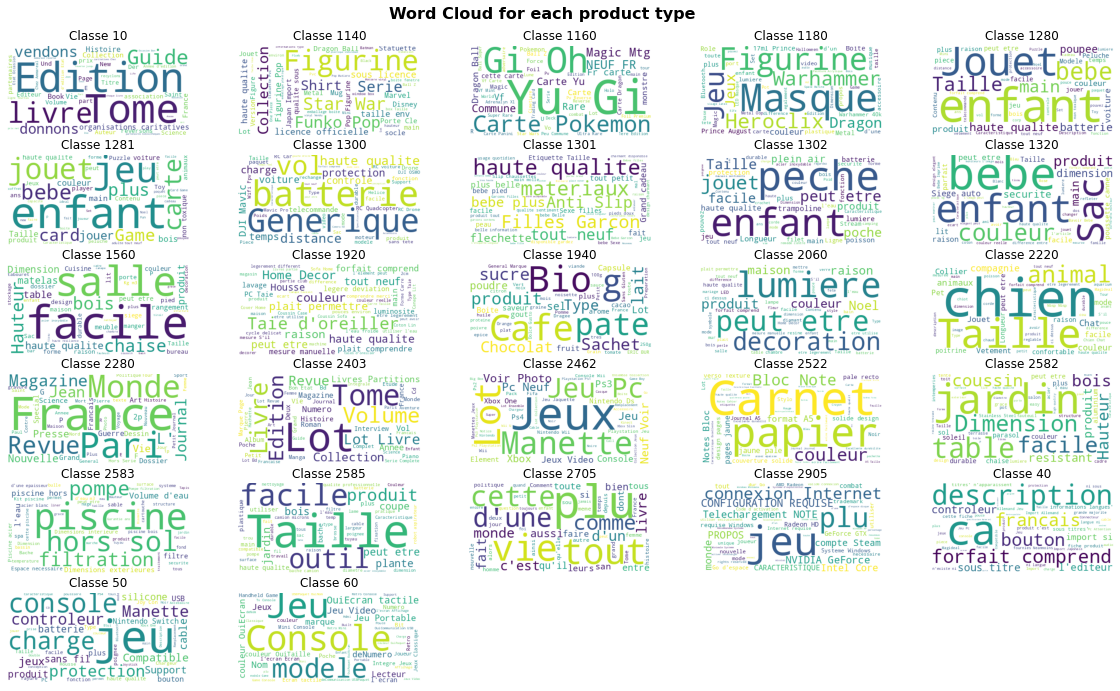

In [ ]:
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from matplotlib.colors import LogNorm
from nltk.corpus import stopwords

# Initialisation des variables
product_type_codes = X_y_train["prdtypecode"].drop_duplicates().sort_values()
n_classe = product_type_codes.count()
imgs_per_code= 5
subfig_side = 2
fig = plt.figure(figsize=(imgs_per_code * 4, n_classe * subfig_side))
overall_title = fig.suptitle("Word Cloud for each product type", fontsize=16, fontweight="bold", y=0.89)

# Initialisation de la variable des mots vides et ajout des balises html
stop_words = set(stopwords.words(['english', 'french']))
exclure_mots = ['x', 'cm', 'h', 'mm']
stop_words.update(exclure_mots)

# Création du modèle word cloud
wordcloud = WordCloud(background_color = 'white', stopwords = stop_words, max_words = 50)

# Création d'un graphique par classe
i = 0
for code in product_type_codes.sort_values():
  i+=1
  text = " ".join(X_y_train[X_y_train["prdtypecode"] == code]["design_describe"])
  wordcloud.generate(text);
  if i <= n_classe:
    fig.add_subplot(n_classe, imgs_per_code, i).set_title("Classe " + str(code))
  plt.plot()
  plt.imshow(wordcloud);
  plt.axis("off");
plt.show();

**Interprétation :**

Cette représentation par classe permet de mettre en évidence les mots les plus fréquents au sein de cette catégorie. Parmi les mots les plus récurrents, on en retrouve certains comme "eau", "piscine", "taille", etc., en lien avec la catégorie '2583' la plus représentée : "Accessoires de piscine"

### *Panel d'images*

In [ ]:
# execution en 10minutes
product_type_codes = X_y_train["prdtypecode"].drop_duplicates().sort_values()

# Display a gallery of product images, with a row per product type code
import matplotlib.pyplot as plt

# One row per type code and imgs_per_code columns
n_codes = product_type_codes.count()
imgs_per_code = 8
# Each image will be nested in a square cell, subfig_side x subfig_side in size
subfig_side = 4

fig = plt.figure(figsize=(imgs_per_code * subfig_side, n_codes * subfig_side))
overall_title = fig.suptitle("A few images for each product type", fontsize=20, fontweight="bold", y=0.885)
i_fig = 0
for code in product_type_codes.sort_values():
  start_column = True
  # For predictable results, either add "random_state=XX" to method "sample", or use method "head" instead
  for img_path in X_y_train[X_y_train["prdtypecode"] == code]["image_path"].sample(imgs_per_code):
    i_fig += 1
    ax = fig.add_subplot(n_codes, imgs_per_code, i_fig)
    ax.set_xticks([])
    ax.set_yticks([])
    if start_column:
      code_title = ax.set_ylabel("Type code {}".format(code), fontsize=16)
    img = plt.imread(img_path)
    ax.imshow(img)

    start_column = False


Output hidden; open in https://colab.research.google.com to view.

**Interprétation :**

Cette représentation permet de visualiser la correspondance des classes de produits par les images. Certaines catégories comme la catégorie 10, Livre d’occasion et 1301, Accessoires enfants, sont difficilement classifiables.


### *Distribution des classes*

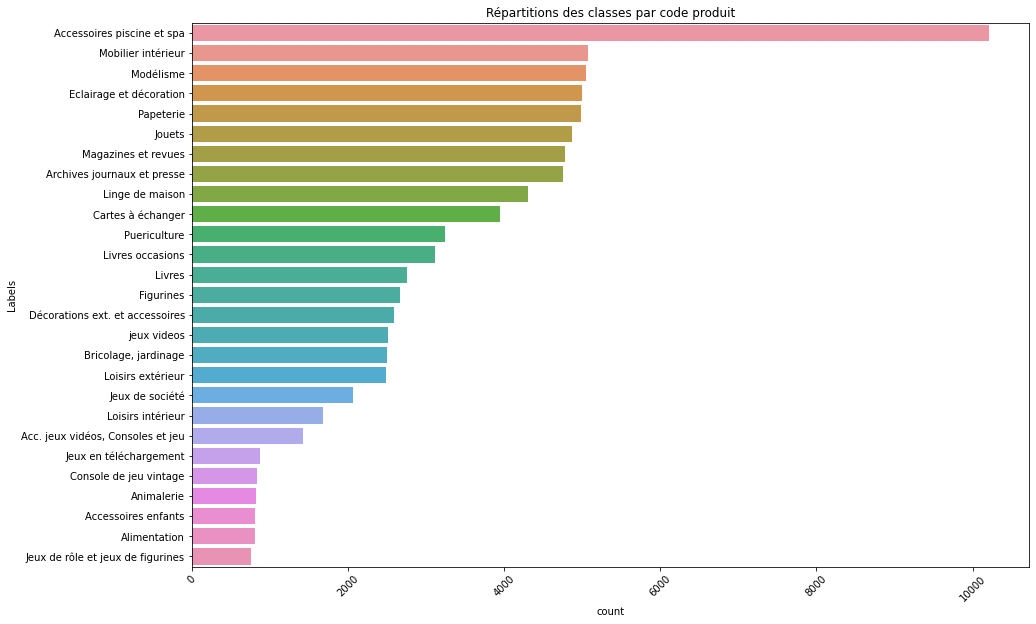

In [ ]:
# Affichage de la distribution des classes
plt.figure(figsize = (15,10))
sns.countplot(y=X_y_train['Labels'], order=X_y_train['Labels'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Répartitions des classes par code produit');


**Interprétation :**

On constate un déséquilibre prononcé dans la représentation des différents types de produit. Le type n°2853, le plus représenté, compte environ 13 fois plus de produits que le type le moins représenté (n°1180).

### *Distribution des classes et des NAs*



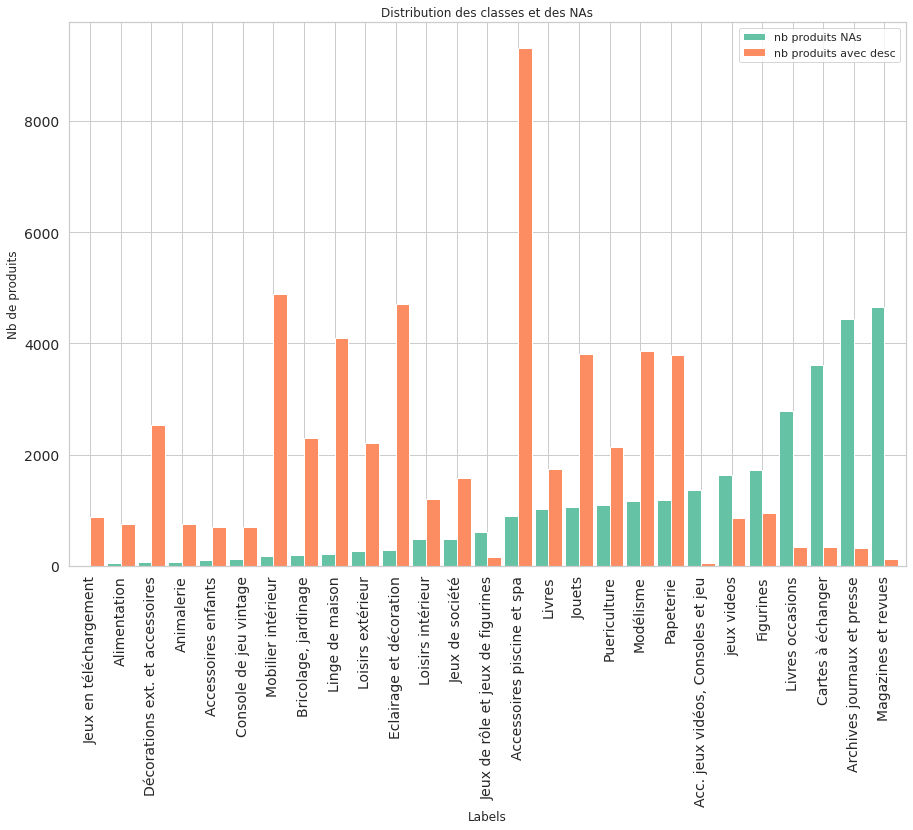

In [ ]:
# comptage du nombre de produits avec valeurs manquantes
class_description = pd.DataFrame(X_y_train_origine.groupby('Labels')['description'].apply(lambda x: x.isna().sum()))
class_description = class_description.rename(columns={'Labels':'Classes','description':'nb produits NAs'})
# comptage du nombre de produits avec valeurs renseignées
class_description['nb produits avec desc']=X_y_train_origine.groupby('Labels')['description'].apply(lambda x: x.notna().sum())

# Afficher la répartition des produits avec description ou sans
sns.set_theme(style='whitegrid', palette='Set2')
ax = class_description.sort_values(by='nb produits NAs').plot.bar(width = 0.9, rot=90, figsize=(15, 10), ylabel='Nb de produits',sort_columns=True, title ='Distribution des classes et des NAs', fontsize=14)



**Interprétation :**

Il est clair que certaines classes de produits sont plus touchées que d'autres par les descriptions manquantes.

Peut-être que certains produits sont davantage vendus par des vendeurs indépendants qui ne prennent pas le temps de saisir une description détaillée. Souvent, l'essentiel des informations se trouve dans le champ 'designation'.

### *Distribution du nombre de caractères designatifs selon la catégorie*

<Figure size 1080x720 with 0 Axes>

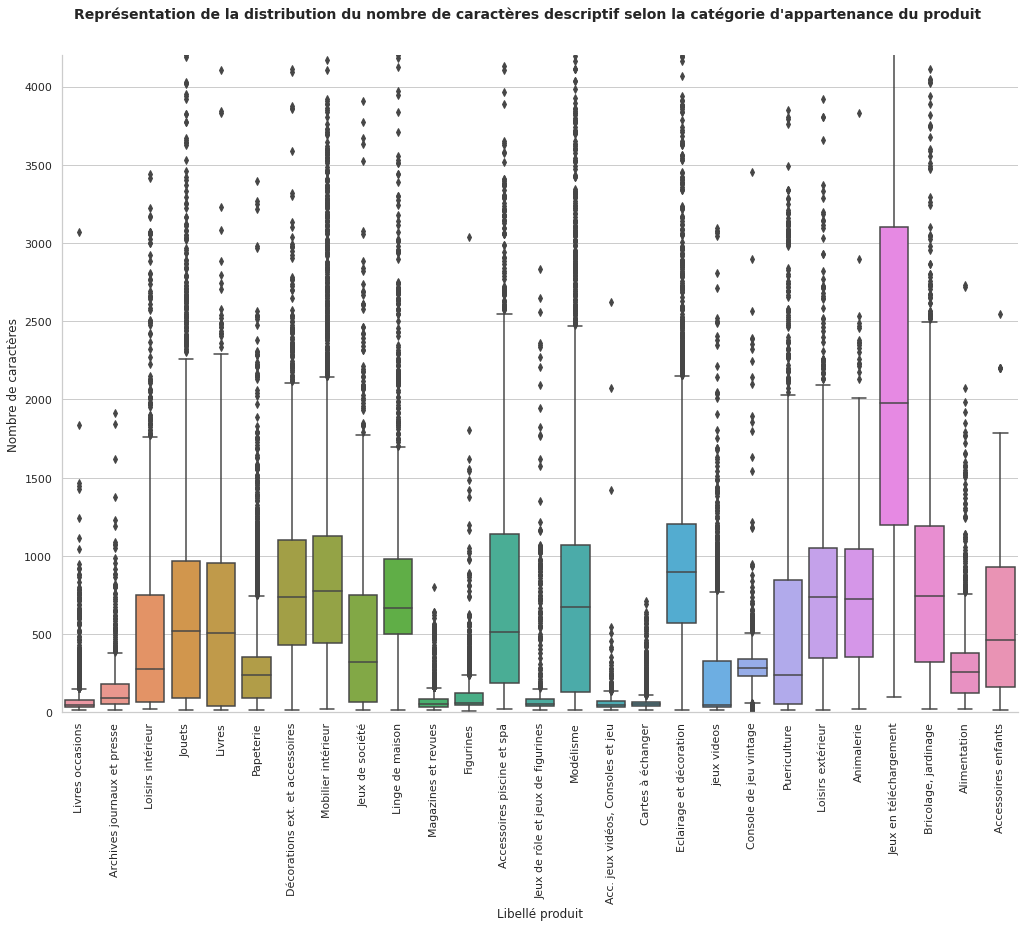

In [ ]:
# Création d'une nouvelle colonne pour compter le nombre de caractères
X_y_train["nombre_de_caracteres"] = X_y_train["design_describe"].apply(lambda x: len(x))

# Creer un boxplot d'abscisse Libellé produit et d'ordonnée nombre_de_caracteres
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

plt.figure(figsize=(15,10));
sns.set(style="whitegrid");

# Création de la figure avec un axe y catégoriel et un axe x quantitatif
g = sns.catplot(data=X_y_train, x='Labels', y='nombre_de_caracteres', kind='box', height=10, aspect=1.5);
g.set(ylim=(0, 4200));

# Personnalisation de la figure
g.set_axis_labels("Libellé produit","Nombre de caractères");
g.set_titles("Représentation de la distribution du nombre de caractères descriptif selon la catégorie d'appartenance du produit, {col_name}");
g.set_xticklabels(rotation=90);

# Récupération de l'objet figure
fig = g.fig;

# Modification du titre de la figure
fig.suptitle("Représentation de la distribution du nombre de caractères descriptif selon la catégorie d'appartenance du produit", y=1.05,fontweight="bold",fontsize=14);

# Affichage de la figure
plt.show();

**Interprétation :**

Cette figure permet de visualiser le nombre de caractères descriptif selon la catégorie d'appartenance du produit.
A titre indicatif, les catégories de produits les moins décrits, sont :
*   10 - Des livres
*   2403 - Des lots de livres et de magazines
*   1140 - Des figurines
*   1180 - Des petits objets de collection
*   2462 - Des jeux vidéos de console
*   1160 - Des cartes de jeux

Et la catégorie de produits la plus décrite est :     

*   2905 - Des jeux PC



### *Taux de produits par catégorie*

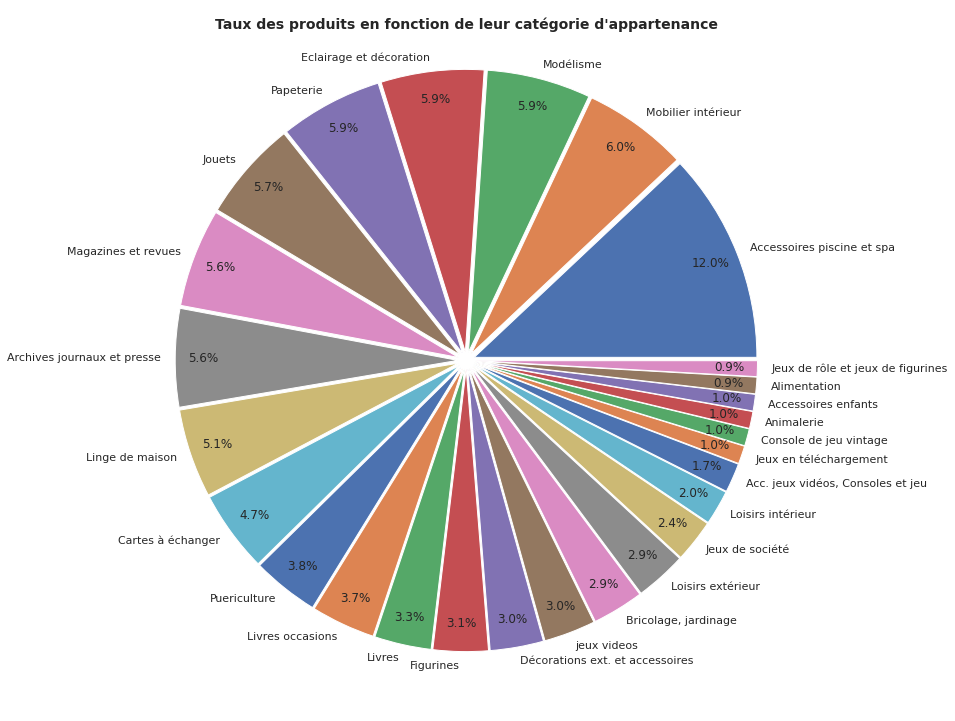

In [ ]:
# Distribution des produits
counts = X_y_train['Labels'].value_counts()

# Création du Diagramme circulaire
plt.figure(figsize=(13, 13))
plt.pie(counts.values, labels=counts.index, autopct='%1.1f%%',pctdistance=0.9,labeldistance=1.05, explode = [.03]*len(counts.values))
plt.title("Taux des produits en fonction de leur catégorie d'appartenance",y=0.96,fontweight="bold",fontsize=14)

# Affichage du diagramme
plt.show()

**Interprétation :**

Cette figure permet de visualiser le taux des produits en fonction de leur catégorie d'appartenance.
Nous pouvons remarquer que les produits de la catégorie ayant le plus de descriptions représentent 1% des produits de cette base de données.


D'ailleurs, la catégorie ayant le plus de produit dans son répertoire est la 2583 (piscines et accessoires) avec 12% des éléments de cette base de données. Cette dernière catégorie semble presenter une description de longueur standard par rapport à l'ensemble des catégories observées.

## ***Classification des images***

### *Importation des données et des packages utiles pour la classification des images*


In [ ]:
from google.colab import drive
import os.path
DRIVE_PATH = "/content/drive/Shareddrives/ds_nov22_cnt_rakuten"
#CSV_FILE_DIR = os.path.join(DRIVE_PATH, "train_test/csv_files")
CSV_FILE_DIR = os.path.join(DRIVE_PATH, "CSV_avec_traduction")
CSV_FILE_DIR1 = os.path.join(DRIVE_PATH, "train_test/images")
IMG_DIR = os.path.join(DRIVE_PATH, "image_train")
IMG_DIR1 = os.path.join(CSV_FILE_DIR1, "image_test")
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install ultralytics
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 629.1/629.1 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 76.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.1
    Uninstalling numpy-1.25.1:
      Successfully uninstalled numpy-1.25.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.7 requires jax>=0.4.6, but you have jax 0.3.25 which is incompatible.
flax 0.7.0 requires jax>=0.4.2, but you have jax 0.3.25 which is incompatible.
orbax-checkpoint 0.2.7 requires jax>=0.4.9, but you have jax 0.3.25 which is incompatible.


Packages utilisés

In [ ]:
import cv2
import glob
import itertools
import os
import time
import threading
import shutil
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from concurrent import futures
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import label_binarize
from tensorflow import keras
from tensorflow.keras import applications, optimizers
from tensorflow.keras.layers import Conv2D, Activation, Dense, MaxPooling2D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LambdaCallback
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
tf.compat.v1.set_random_seed(2019)


In [ ]:
current_path = os.getcwd()
current_path
images_path = current_path + r'/drive/Shareddrives/ds_nov22_cnt_rakuten/image_train'
images_path
images_list = os.listdir(images_path)

Raccourci pour l'importation du Dataframe



In [ ]:
df=pd.read_csv(os.path.join(CSV_FILE_DIR, "df_avec_traduction.csv"))
df.head(2)

designation description   productid  \
0  Olivia: Personalisiertes Notizbuch / 150 Seite...         NaN  3804725264   
1  Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...         NaN   436067568   

      imageid                                         image_path  prdtypecode  \
0  1263597046  /content/drive/Shareddrives/ds_nov22_cnt_rakut...           10   
1  1008141237  /content/drive/Shareddrives/ds_nov22_cnt_rakut...         2280   

                        Labels  \
0             Livres occasions   
1  Archives journaux et presse   

                                     design_describe  \
0  Olivia: Personalisiertes Notizbuch / 150 Seite...   
1  Journal Des Arts (Le) N 133 Du 28/09/2001 - L'...   

                                      designe_decrit  
0  Olivia : Carnet personnalisé / 150 pages / Dot...  
1  Journal Des Arts (Le) N 133 Du 28/09/2001 - L'...


### *Classification des images avec le modèle Inception de Keras*

In [ ]:
df.head(2)

designation description   productid  \
0  Olivia: Personalisiertes Notizbuch / 150 Seite...         NaN  3804725264   
1  Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...         NaN   436067568   

      imageid                                         image_path  prdtypecode  \
0  1263597046  /content/drive/Shareddrives/ds_nov22_cnt_rakut...           10   
1  1008141237  /content/drive/Shareddrives/ds_nov22_cnt_rakut...         2280   

                        Labels  \
0             Livres occasions   
1  Archives journaux et presse   

                                     design_describe  \
0  Olivia: Personalisiertes Notizbuch / 150 Seite...   
1  Journal Des Arts (Le) N 133 Du 28/09/2001 - L'...   

                                      designe_decrit  
0  Olivia : Carnet personnalisé / 150 pages / Dot...  
1  Journal Des Arts (Le) N 133 Du 28/09/2001 - L'...

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df[['image_path','Labels']], df.Labels, test_size=0.2, random_state=42)
val_split = 0.1

In [ ]:
val_indices = int(len(X_train) * val_split)
new_x_train, new_y_train = X_train[val_indices:], y_train[val_indices:]
x_val, y_val = X_train[:val_indices], y_train[:val_indices]

In [ ]:
img_width, img_height = 299, 299
image_generator = ImageDataGenerator(validation_split=0.3)
batch_size=32

In [ ]:
train_generator = image_generator.flow_from_dataframe(dataframe=new_x_train, x_col = "image_path", y_col = "Labels",
                                                              batch_size=batch_size, # directory=path,
                                                              class_mode='categorical',
                                                              subset="training",
                                                               shuffle=True,
                                                              target_size=(img_height, img_width))

val_generator = image_generator.flow_from_dataframe(dataframe=x_val,x_col = "image_path", y_col = "Labels",
                                                              batch_size=batch_size, # directory=path,
                                                              class_mode='categorical',
                                                              subset="validation",
                                                              shuffle=True,
                                                              target_size=(img_height, img_width))

test_generator = image_generator.flow_from_dataframe(dataframe=X_test, x_col = "image_path", y_col = "Labels",
                                                              batch_size=batch_size, # directory=path,
                                                              class_mode='categorical',
                                                               shuffle=True,
                                                              target_size=(img_height, img_width))

Found 42798 validated image filenames belonging to 27 classes.
Found 2037 validated image filenames belonging to 27 classes.
Found 16984 validated image filenames belonging to 27 classes.


In [ ]:
base_model = applications.inception_v3.InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(27, activation= 'softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(lr=0.001),
              metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('Inception_v3_TL_flowers.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=False,
                             period=1,
                             verbose=1)

In [ ]:
callbacks = [checkpoint]
epochs = 20
batch_size = 32

In [ ]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch =100, # train_generator.samples // batch_size,
    validation_data = val_generator,
    validation_steps =50, # val_generator.samples // batch_size,
    epochs = epochs,
    callbacks=callbacks
    )

model.save('Inception_v3_TL_flowers.h5')

<ipython-input-17-ca79109f6205>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 2.6791 - accuracy: 0.2634
Epoch 1: saving model to Inception_v3_TL_flowers.h5
100/100 [==============================] - 1290s 13s/step - loss: 2.6791 - accuracy: 0.2634 - val_loss: 2.1964 - val_accuracy: 0.3950
Epoch 2/20
100/100 [==============================] - ETA: 0s - loss: 2.0584 - accuracy: 0.4144
Epoch 2: saving model to Inception_v3_TL_flowers.h5
100/100 [==============================] - 854s 9s/step - loss: 2.0584 - accuracy: 0.4144 - val_loss: 1.8889 - val_accuracy: 0.4700
Epoch 3/20
100/100 [==============================] - ETA: 0s - loss: 1.8853 - accuracy: 0.4706
Epoch 3: saving model to Inception_v3_TL_flowers.h5
100/100 [==============================] - 719s 7s/step - loss: 1.8853 - accuracy: 0.4706 - val_loss: 1.7588 - val_accuracy: 0.4875
Epoch 4/20
100/100 [==============================] - ETA: 0s - loss: 1.7826 - accuracy: 0.4781
Epoch 4: saving model to Inception_v3_TL_flowers.h5
100/100 [=

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


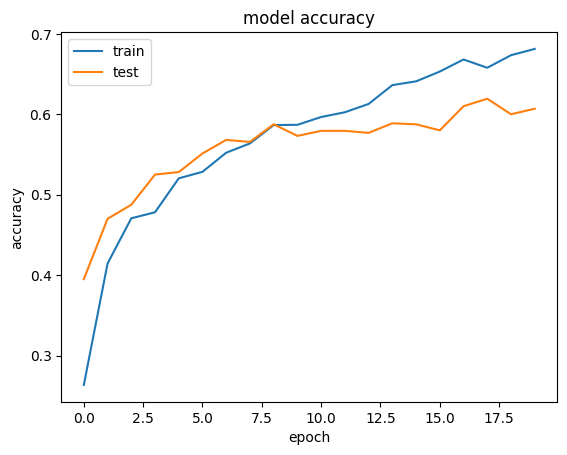

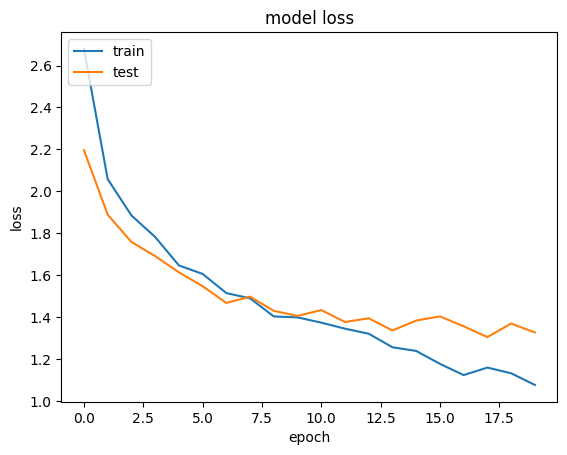

In [ ]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

**Intéprétabilité :** Dans l'expérience de classification d'images utilisant le modèle Inception de Keras, un entrainement sur 20 époques avec un lot de taille 32 a montré une progression constante de la performance du modèle. La perte sur les données d'entraînement et de validation a continué à diminuer, tandis que l'accuracy s'est améliorée pour atteindre 68,12% sur les données d'entraînement. Cependant, malgré cette amélioration, l'accuracy sur l'ensemble de validation était légèrement inférieure, atteignant 60,69%. Cela peut indiquer une certaine mesure de surapprentissage, bien que la performance sur les données de validation reste relativement élevée, suggérant que le modèle a tout de même réussi à généraliser assez efficacement à partir des données d'entraînement.



In [ ]:
#model.load_weights(Inception_v3_TL_flowers.h5)

In [ ]:
predict = model.predict(test_generator)
predictions = np.argmax(predict, axis=1) # decision
true_labels = np.array(test_generator.classes)

In [ ]:
predict = model.predict(test_generator)
predictions = np.argmax(predict, axis=1) # decision
true_labels = np.array(test_generator.classes)

531/531 [==============================] - 4156s 8s/step


In [ ]:
import itertools
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):


    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(30, 20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

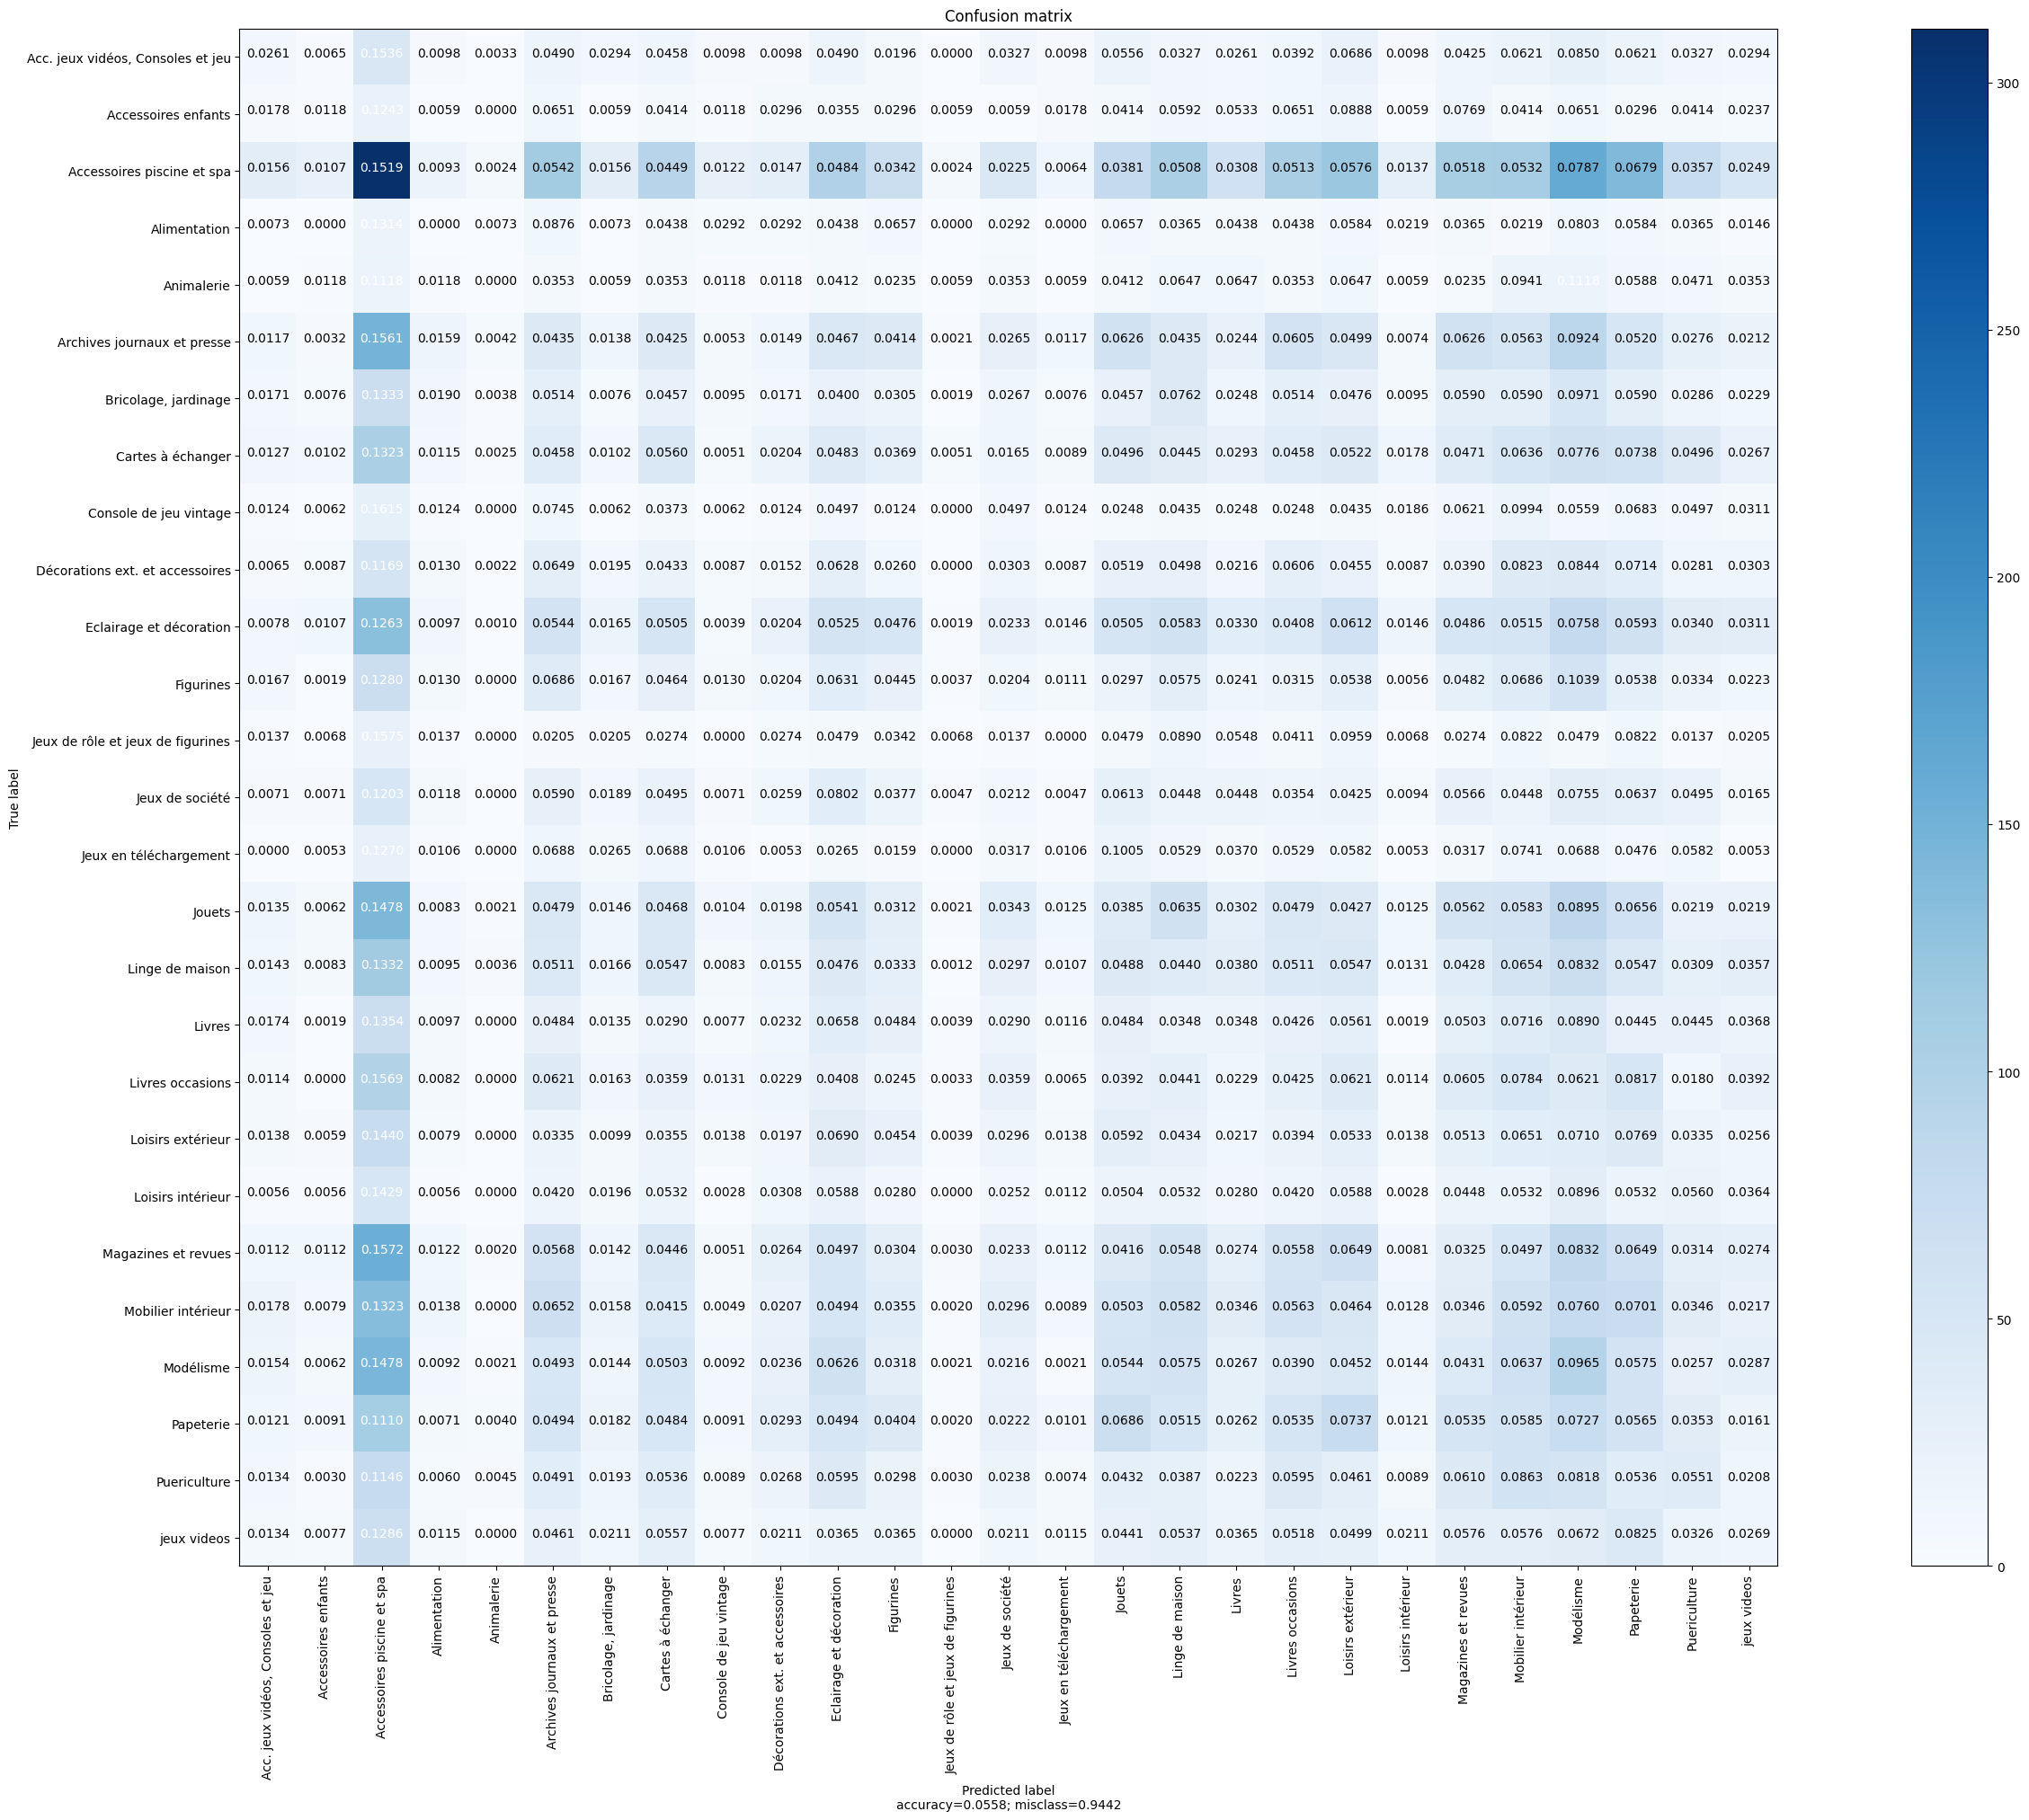

In [ ]:
cm = sklearn.metrics.confusion_matrix(true_labels, predictions)
target_names =train_generator.class_indices
plot_confusion_matrix(cm,target_names)

In [ ]:
test_score = model.evaluate(test_generator)
print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100))
print("[INFO] Loss: ",test_score[0])

531/531 [==============================] - 142s 267ms/step - loss: 1.2952 - accuracy: 0.6169
[INFO] accuracy: 61.69%
[INFO] Loss:  1.2951680421829224


In [ ]:
val_score = model.evaluate(val_generator)
print("[INFO] accuracy: {:.2f}%".format(val_score[1] * 100))
print("[INFO] Loss: ",val_score[0])

64/64 [==============================] - 20s 304ms/step - loss: 1.3247 - accuracy: 0.6043
[INFO] accuracy: 60.43%
[INFO] Loss:  1.324686050415039


In [ ]:
train_score = model.evaluate(train_generator)
print("[INFO] accuracy: {:.2f}%".format(train_score[1] * 100))
print("[INFO] Loss: ",train_score[0])

1338/1338 [==============================] - 2419s 2s/step - loss: 0.9427 - accuracy: 0.7209
[INFO] accuracy: 72.09%
[INFO] Loss:  0.9427122473716736


**Conclusion :** En résumé, le modèle Inception semble bien performer sur l'ensemble d'entraînement, mais sa performance est légèrement réduite sur les ensembles de validation et de test.


### *Classification des images avec le modèle Xception de Keras*

In [ ]:
df=pd.read_csv(os.path.join(CSV_FILE_DIR, "df_avec_traduction.csv"))
df.head(2)

designation description   productid  \
0  Olivia: Personalisiertes Notizbuch / 150 Seite...         NaN  3804725264   
1  Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...         NaN   436067568   

      imageid                                         image_path  prdtypecode  \
0  1263597046  /content/drive/Shareddrives/ds_nov22_cnt_rakut...           10   
1  1008141237  /content/drive/Shareddrives/ds_nov22_cnt_rakut...         2280   

                        Labels  \
0             Livres occasions   
1  Archives journaux et presse   

                                     design_describe  \
0  Olivia: Personalisiertes Notizbuch / 150 Seite...   
1  Journal Des Arts (Le) N 133 Du 28/09/2001 - L'...   

                                      designe_decrit  
0  Olivia : Carnet personnalisé / 150 pages / Dot...  
1  Journal Des Arts (Le) N 133 Du 28/09/2001 - L'...

In [ ]:
df['image_name'] = 'image_' + df['imageid'].map(str) + '_product_' + df['productid'].map(str) + '.jpg'
print(df['image_name'].loc[0])

image_1263597046_product_3804725264.jpg


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df[['image_path','Labels']], df.Labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 42)
y_test

36138         Jeux en téléchargement
68630                Jeux de société
36172        Eclairage et décoration
9830                          Jouets
28422    Archives journaux et presse
                    ...             
40234    Archives journaux et presse
9183               Cartes à échanger
63404           Bricolage, jardinage
80127                      Papeterie
13914                Linge de maison
Name: Labels, Length: 16984, dtype: object

In [ ]:
train_gen = ImageDataGenerator(rescale=1/255.0,
                                     width_shift_range=0.15,
                                     height_shift_range=0.15,
                                     zoom_range=0.2,
                                     fill_mode = 'nearest')

train_dataset = train_gen.flow_from_dataframe(dataframe=X_train,x_col = "image_path", y_col = "Labels",
                                              batch_size=64,
                                                 shuffle=True,
                                                 color_mode = 'rgb',
                                                 target_size=(125, 125),
                                                 class_mode='categorical')

validation_gen = ImageDataGenerator(rescale=1/255.0)

validation_dataset = validation_gen.flow_from_dataframe(dataframe=X_val,x_col = "image_path", y_col = "Labels",
                                                  batch_size=64,
                                                 shuffle=True,
                                                 color_mode = 'rgb',
                                                 target_size=(125, 125),
                                                 class_mode='categorical')
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(dataframe=X_test,
        target_size=(125, 125),x_col = "image_path", y_col = "Labels",
        color_mode="rgb",
        shuffle = False,
        class_mode='categorical',
        batch_size=1)

Found 61138 validated image filenames belonging to 27 classes.
Found 6794 validated image filenames belonging to 27 classes.
Found 16984 validated image filenames belonging to 27 classes.


In [ ]:
xception = tf.keras.applications.Xception(include_top=False, input_shape=(125,125,3), weights='imagenet')

for layer in xception.layers:
  layer.trainable = False

xception.summary()

83683744/83683744 [==============================] - 0s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 125, 125, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 62, 62, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 62, 62, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                          

In [ ]:
xception_out = xception.get_layer('block12_sepconv1_bn').output

x = Conv2D(512, (3,3), padding = 'same', activation = tf.keras.layers.LeakyReLU(alpha = 0.2))(xception_out)
x = BatchNormalization(momentum=0.9)(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(1024, (3,3), padding = 'same', activation = tf.keras.layers.LeakyReLU(alpha = 0.2))(x)
x = BatchNormalization(momentum=0.9)(x)
x = MaxPooling2D((2,2))(x)

x = tf.keras.layers.Flatten()(x)

x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)

output_xception = Dense(27, activation='softmax')(x)

model_xception = tf.keras.models.Model(inputs = xception.input, outputs = output_xception)

In [ ]:
opt = tf.keras.optimizers.Adam(lr = 0.0001)
model_xception.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

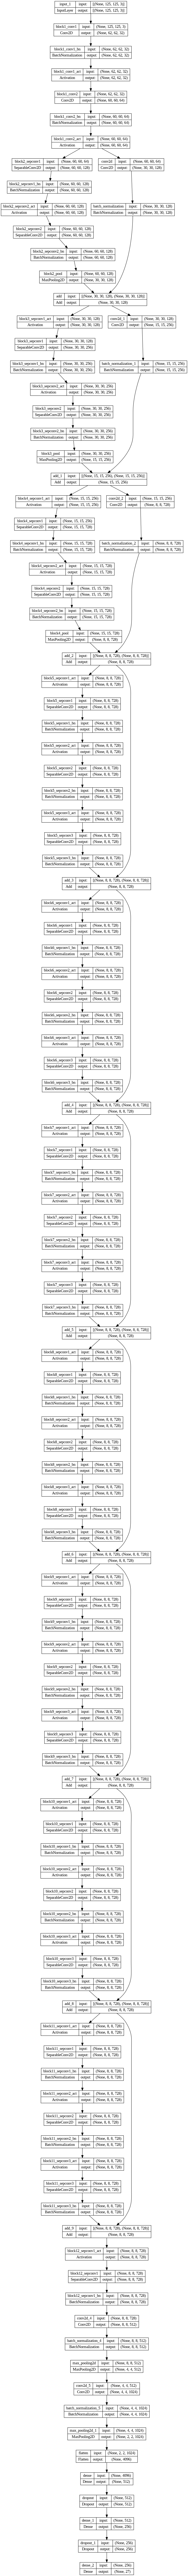

In [ ]:
tf.keras.utils.plot_model(model_xception, 'model.png', show_shapes= True)

**Explication :** Ensuite, nous appelons la méthode "fit" pour optimiser le modèle en 48 époques, puis effectuer des prédictions.




In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 7, verbose = 1)
rd_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor = np.sqrt(0.1), patience= 3, verbose = 1, min_lr = 5e-8)

history = model_xception.fit(train_dataset, epochs= 48, validation_data= validation_dataset,steps_per_epoch=100,
                validation_steps=50, workers=-1, callbacks =[rd_lr,es])

Epoch 1/48
100/100 [==============================] - 2610s 26s/step - loss: 3.1653 - accuracy: 0.1598 - val_loss: 2.5328 - val_accuracy: 0.2634 - lr: 0.0010
Epoch 2/48
100/100 [==============================] - 1999s 20s/step - loss: 2.7590 - accuracy: 0.2116 - val_loss: 2.4136 - val_accuracy: 0.2975 - lr: 0.0010
Epoch 3/48
100/100 [==============================] - 1600s 16s/step - loss: 2.5840 - accuracy: 0.2531 - val_loss: 2.3311 - val_accuracy: 0.3325 - lr: 0.0010
Epoch 4/48
100/100 [==============================] - 1389s 14s/step - loss: 2.5032 - accuracy: 0.2802 - val_loss: 2.2040 - val_accuracy: 0.3628 - lr: 0.0010
Epoch 5/48
100/100 [==============================] - 1225s 12s/step - loss: 2.4537 - accuracy: 0.3003 - val_loss: 2.1908 - val_accuracy: 0.3622 - lr: 0.0010
Epoch 6/48
100/100 [==============================] - 1043s 10s/step - loss: 2.3868 - accuracy: 0.3063 - val_loss: 2.2388 - val_accuracy: 0.3400 - lr: 0.0010
Epoch 7/48
100/100 [==============================] 

**Intéprétabilité :**  Dans l'exercice de classification d'images avec le modèle Xception, une formation sur 48 époques a montré une évolution progressive des performances. Le taux d'apprentissage a été réduit deux fois, à la 45ème et 48ème époque, stabilisant ainsi l'entraînement. À la fin, l'accuracy atteint 50.70% sur les données d'entraînement et 52.69% sur les données de validation. Cet écart modeste suggère un bon équilibre entre biais et variance, bien qu'il indique une légère tendance au surapprentissage.

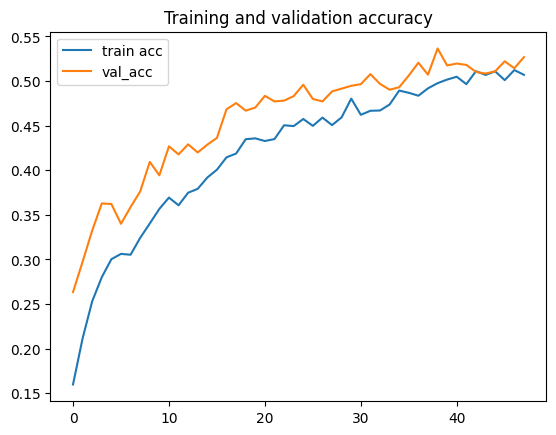

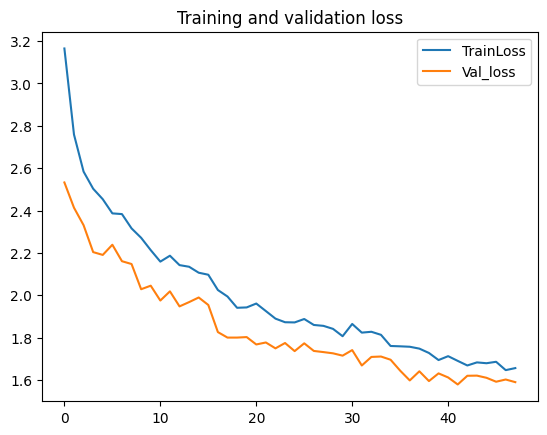

In [ ]:
# %% Check Plots
acc= history.history['accuracy']
val_acc= history.history['val_accuracy']
loss= history.history['loss']
val_loss= history.history['val_loss']

epochs= range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot( epochs, acc, label = 'train acc' )
plt.plot( epochs, val_acc, label = 'val_acc' )
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig('Accuracy Graph Tuned')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot( epochs,     loss, label = 'TrainLoss' )
plt.plot( epochs, val_loss, label = 'Val_loss' )
plt.title('Training and validation loss'   )
plt.savefig('Loss Graph Tuned')
plt.legend()

plt.show()

**Observation :**  Malgré un nombre d'époques supérieur, les performances du modèle Xception sont légèrement inférieures à celles du modèle Inception.
Cependant, l'écart plus faible entre les accuracies d'entraînement et de validation du modèle Xception suggère qu'il pourrait être moins sujet au surapprentissage que le modèle Inception.

In [ ]:
filenames = test_generator.filenames
nb_samples = len(filenames)

predict = model_xception.predict(test_generator,steps = nb_samples)
predictions = predict.argmax(axis = 1)
true_labels = test_generator.classes

16984/16984 [==============================] - 4724s 278ms/step


In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):


    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(30, 20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

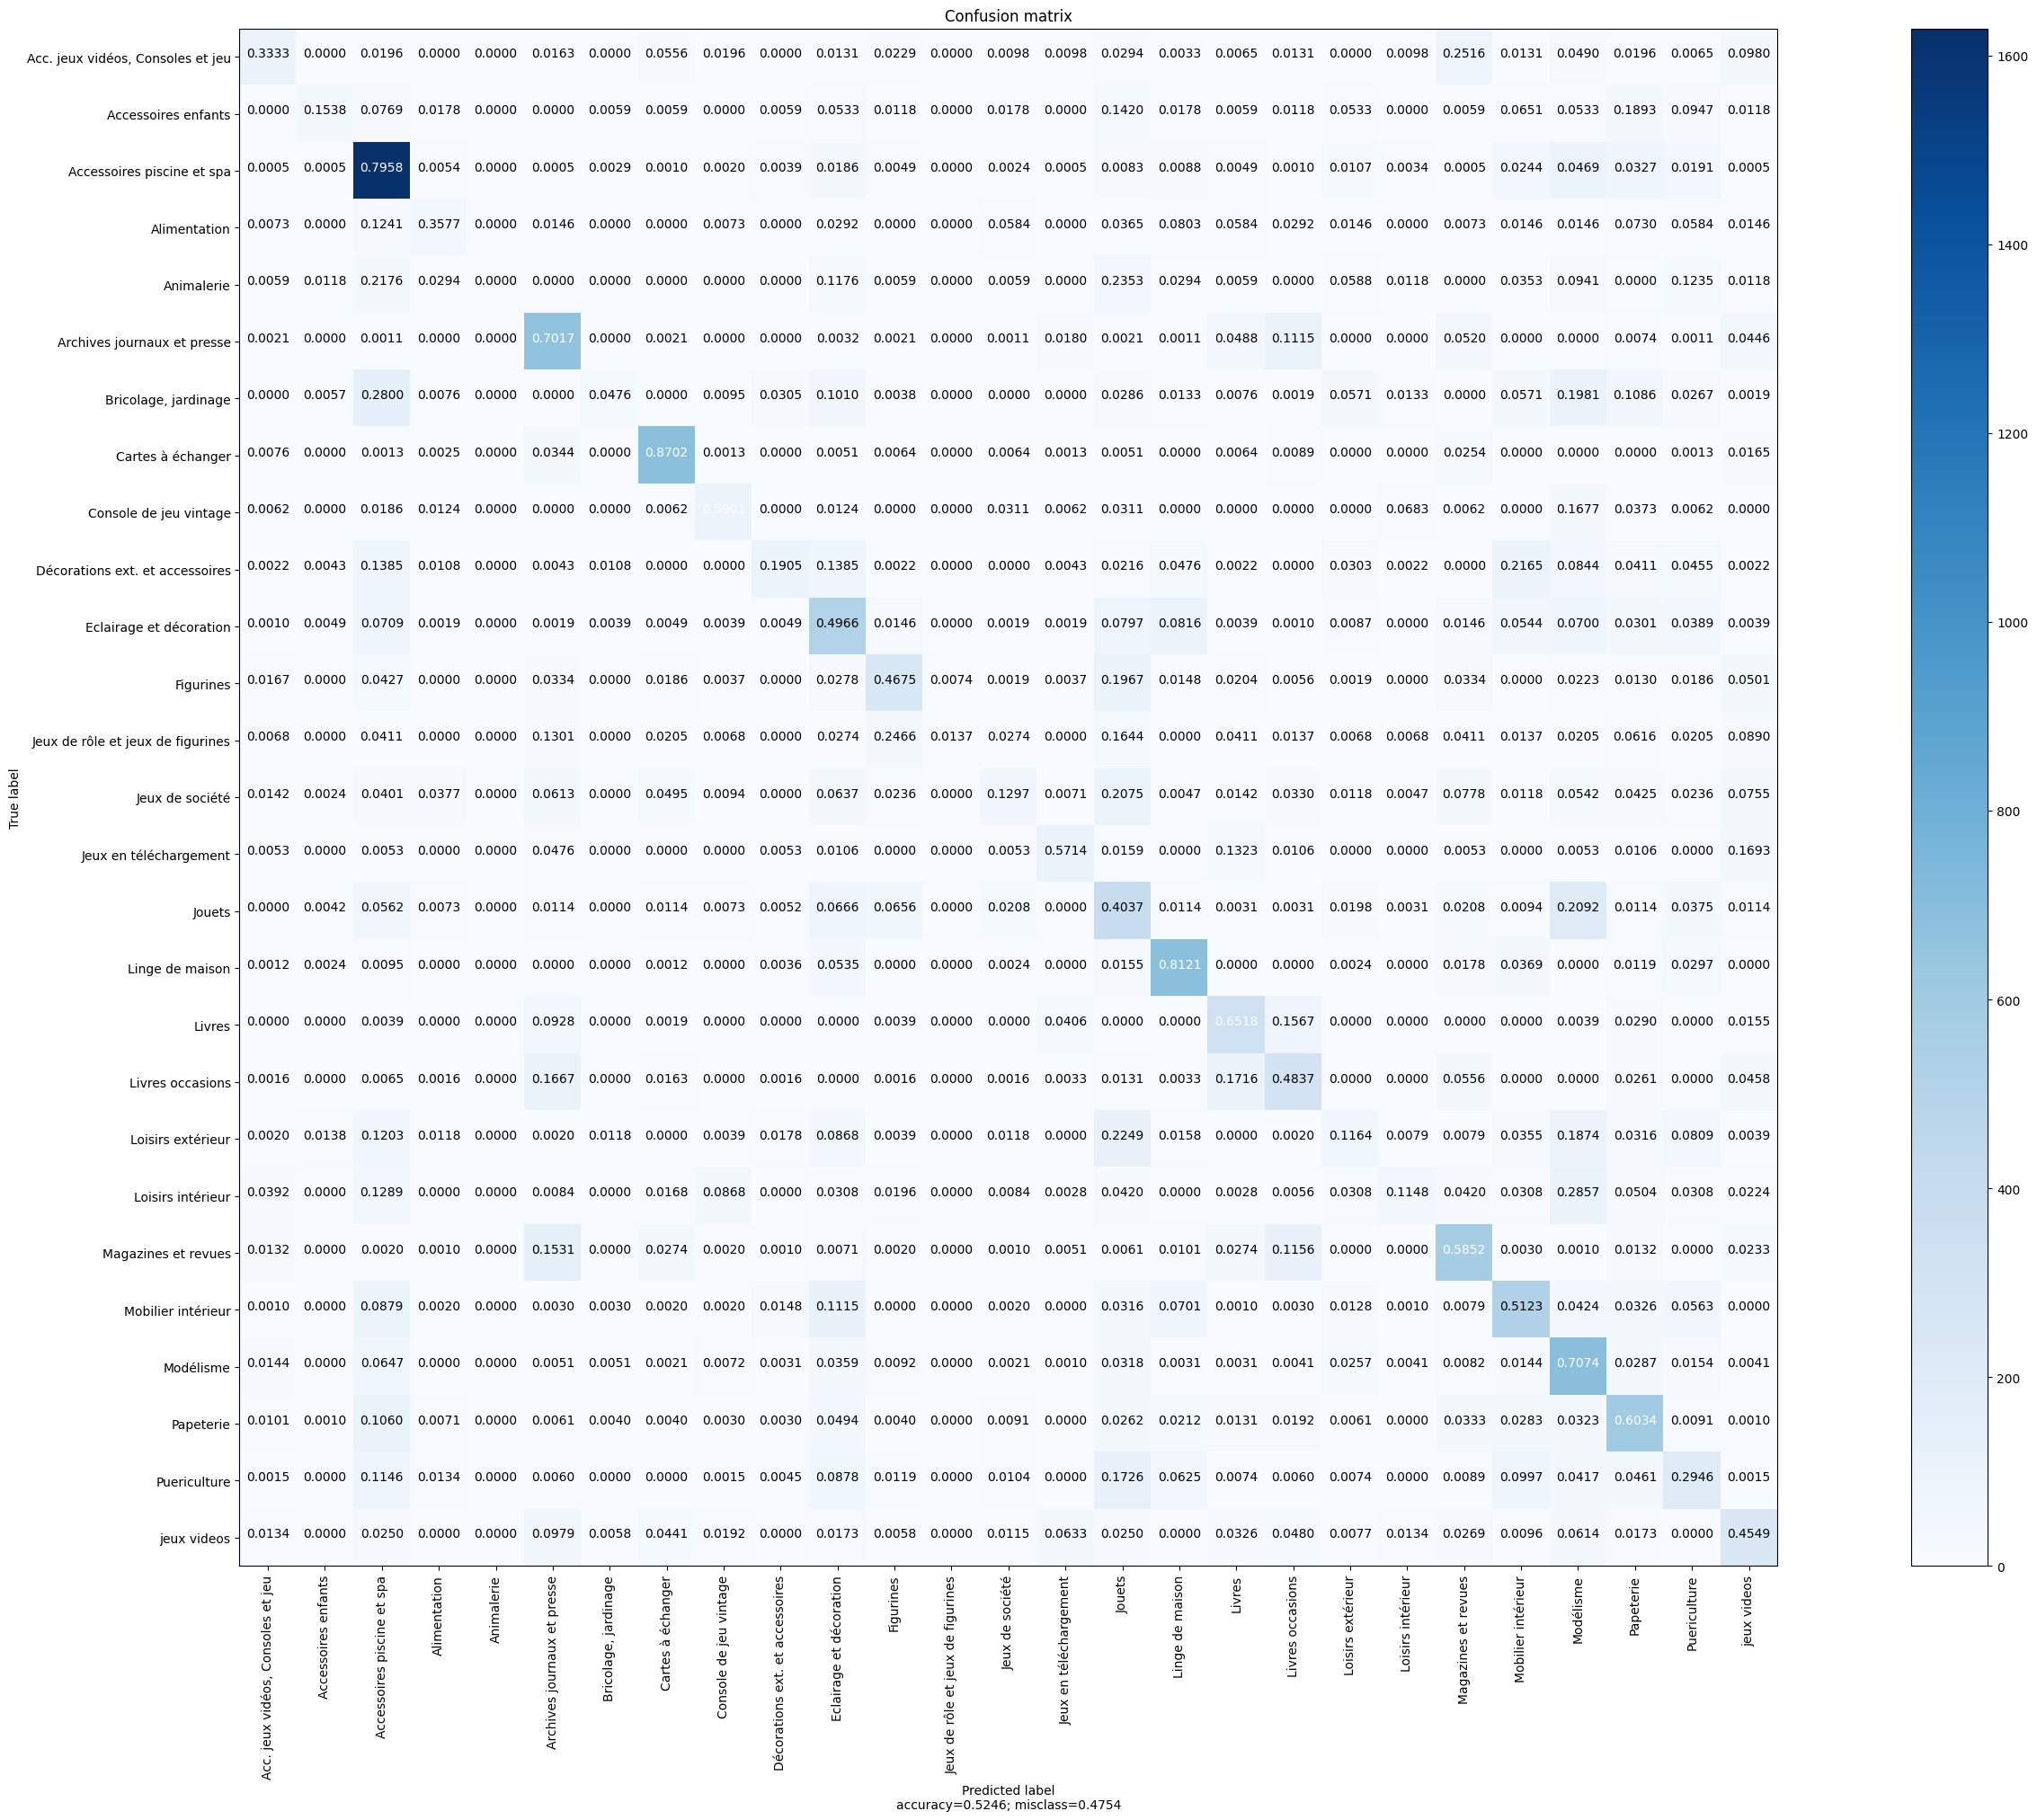

In [ ]:
cm = sklearn.metrics.confusion_matrix(true_labels, predictions)
target_names =train_dataset.class_indices
plot_confusion_matrix(cm,target_names)

Le modèle Xception offre une matrice de confusion avecc une diagonale plus définie, ceci incité à penser que ce modèle peut prédire avec une plus grande précision la classe réelle d'une image donnée.
Cette diagonale mieux définie indique que le modèle Xception fait correctement correspondre les prédictions et les véritables classes d'une manière plus cohérente que le modèle Inception.

In [ ]:
test_score = model_xception.evaluate_generator(test_generator)
print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100))
print("[INFO] Loss: ",test_score[0])

<ipython-input-26-900c680a7ba2>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_score = model_xception.evaluate_generator(test_generator)


[INFO] accuracy: 52.46%
[INFO] Loss:  1.5813196897506714


In [ ]:
val_score = model_xception.evaluate_generator(validation_dataset)
print("[INFO] accuracy: {:.2f}%".format(val_score[1] * 100))
print("[INFO] Loss: ",val_score[0])

<ipython-input-41-1727d1a1315e>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  val_score = model_xception.evaluate_generator(validation_dataset)


[INFO] accuracy: 52.90%
[INFO] Loss:  1.5800635814666748


In [ ]:
train_score = model_xception.evaluate_generator(train_dataset)
print("[INFO] accuracy: {:.2f}%".format(train_score[1] * 100))
print("[INFO] Loss: ",train_score[0])

<ipython-input-42-c194b459c7e8>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  train_score = model_xception.evaluate_generator(train_dataset)


[INFO] accuracy: 54.04%
[INFO] Loss:  1.555008888244629


### *Classification des images avec un CNN classique de Keras*



In [ ]:
# Variables
taille = 256
batch_size = 64
path = "/content/drive/Shareddrives/ds_nov22_cnt_rakuten/CSV_avec_traduction/"

# Chargement des données
df = pd.read_csv(path + "df_avec_traduction.csv")
df = df[:40000].copy()
df['prdtypecode'] = df['prdtypecode'].astype('int')

# Label Encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df["prdtypecode"] = le.fit_transform(df["prdtypecode"])



In [ ]:
# Séparation des données
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["prdtypecode"])
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df["prdtypecode"])

# Prétraitement des images
def supprimer_images_inexistantes(df):
    """Vérifie si le fichier image existe pour chaque ligne du DataFrame."""
    df_existants = df[df['image_path'].apply(lambda x: os.path.isfile(x))]
    return df_existants

train_df = supprimer_images_inexistantes(train_df)
val_df = supprimer_images_inexistantes(val_df)
test_df = supprimer_images_inexistantes(test_df)

# Définition des générateurs
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

image_size = (taille, taille)
num_classes = len(train_df['prdtypecode'].unique())

# Générateurs de données
train_generator = train_datagen.flow_from_dataframe(train_df, directory=path, x_col="image_path", y_col="prdtypecode",
                                                    target_size=image_size, batch_size=batch_size, class_mode='raw', shuffle=True)
val_generator = val_datagen.flow_from_dataframe(val_df, directory=path, x_col="image_path", y_col="prdtypecode",
                                                target_size=image_size, batch_size=batch_size, class_mode='raw')
test_generator = test_datagen.flow_from_dataframe(test_df, directory=path, x_col="image_path", y_col="prdtypecode",
                                                  target_size=image_size, batch_size=batch_size, class_mode='raw')


Found 25600 validated image filenames.
Found 6400 validated image filenames.
Found 8000 validated image filenames.


In [ ]:
# Construction du modèle
model = Sequential([
    Conv2D(8, (3, 3), activation='relu', input_shape=(*image_size, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])



In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Création du callback qui sauvegarde le modèle après chaque époque
checkpoint = ModelCheckpoint('modele_cnn.h5', save_best_only=True, monitor='val_loss', mode='min')

# Entraînement
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
times = []
timing_callback = LambdaCallback(on_epoch_begin=lambda epoch, logs: times.append(time.time()))

# Ajout du callback
history = model.fit(train_generator, epochs=12, validation_data=val_generator,
                    callbacks=[timing_callback, early_stop, checkpoint])

durations = [times[i+1] - times[i] for i in range(len(times)-1)]
print('Durations (s) : ', durations)


Epoch 1/12
400/400 [==============================] - 7867s 20s/step - loss: 3.0821 - accuracy: 0.1318 - val_loss: 3.0609 - val_accuracy: 0.1544
Epoch 2/12
400/400 [==============================] - 313s 782ms/step - loss: 2.8257 - accuracy: 0.1924 - val_loss: 2.8216 - val_accuracy: 0.2053
Epoch 3/12
400/400 [==============================] - 313s 782ms/step - loss: 2.6277 - accuracy: 0.2328 - val_loss: 2.5904 - val_accuracy: 0.2736
Epoch 4/12
400/400 [==============================] - 313s 781ms/step - loss: 2.4841 - accuracy: 0.2796 - val_loss: 2.5621 - val_accuracy: 0.2845
Epoch 5/12
400/400 [==============================] - 313s 781ms/step - loss: 2.3919 - accuracy: 0.3065 - val_loss: 2.6167 - val_accuracy: 0.2547
Epoch 6/12
400/400 [==============================] - 312s 780ms/step - loss: 2.3047 - accuracy: 0.3378 - val_loss: 2.3458 - val_accuracy: 0.3356
Epoch 7/12
400/400 [==============================] - 313s 781ms/step - loss: 2.2561 - accuracy: 0.3507 - val_loss: 2.3611 - 

L'augmentation des données est une stratégie qui permet d'augmenter la diversité et la quantité de vos données d'entraînement sans réellement collecter de nouvelles données. En modifiant légèrement les images de l'ensemble d'entraînement (par exemple, en effectuant des rotations, des décalages, des zooms, des flips), votre modèle peut apprendre à généraliser à partir de variations d'images qu'il n'a jamais vues auparavant. Cela peut aider à améliorer la robustesse de votre modèle et à réduire le surapprentissage.

Cependant, l'augmentation des données n'est généralement pas appliquée aux ensembles de validation et de test. Voici pourquoi :

    Ensemble de validation : Cet ensemble est utilisé pour évaluer comment le modèle se comporte sur des données qu'il n'a pas vues lors de l'entraînement, et pour ajuster les hyperparamètres du modèle. Si nous augmentons les données de validation, nous introduisons une source de variabilité qui pourrait fausser notre compréhension de la performance du modèle.

    Ensemble de test : Cet ensemble est utilisé pour évaluer le modèle final et donner une estimation de sa performance en conditions réelles. Pour obtenir une évaluation fidèle, il est essentiel que les données de test soient aussi proches que possible des véritables données que le modèle rencontrera en production.

In [ ]:
# voir les données de
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 8)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 8)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      2336      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 62, 62, 32)        0

In [ ]:
# Sauvegarde
model_save_path = os.path.join(DRIVE_PATH, "my_model_cnn_version_commune.h5")
model.save(model_save_path)


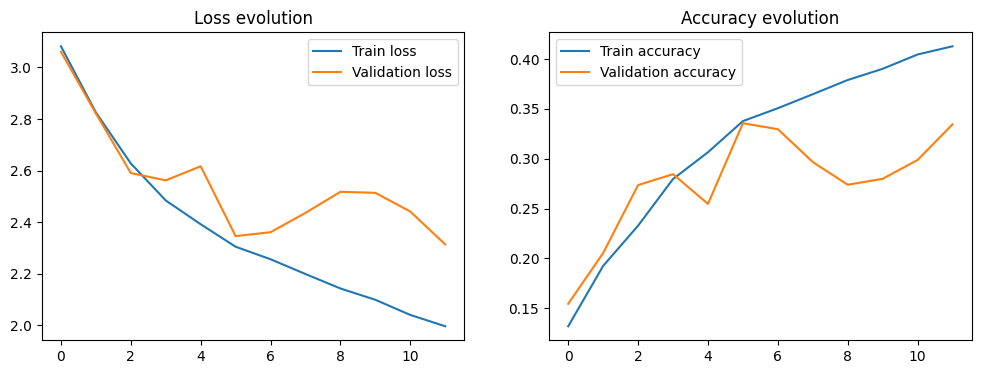

In [ ]:
# courbes de perte
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss evolution')
plt.legend()

# courbes de précision
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Accuracy evolution')
plt.legend()

plt.show()


In [ ]:
# Methode pour evaluer le modèle sur les données de test
loss, accuracy = model.evaluate(test_generator)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


125/125 [==============================] - 2241s 18s/step - loss: 2.3125 - accuracy: 0.3346
Test Loss: 2.3125
Test Accuracy: 0.3346


100/100 [==============================] - 57s 570ms/step
Test Report
              precision    recall  f1-score   support

           0       0.06      0.04      0.05       286
           1       0.04      0.04      0.04       234
           2       0.00      0.00      0.00       160
           3       0.00      0.00      0.00        77
           4       0.00      0.00      0.00       252
           5       0.05      0.04      0.05       359
           6       0.00      0.00      0.00        71
           7       0.06      0.08      0.07       452
           8       0.00      0.00      0.00       190
           9       0.06      0.09      0.07       479
          10       0.00      0.00      0.00        73
          11       0.00      0.00      0.00       241
          12       0.05      0.01      0.02       321
          13       0.06      0.19      0.10       487
          14       0.06      0.11      0.08       418
          15       0.00      0.00      0.00        70
          1

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

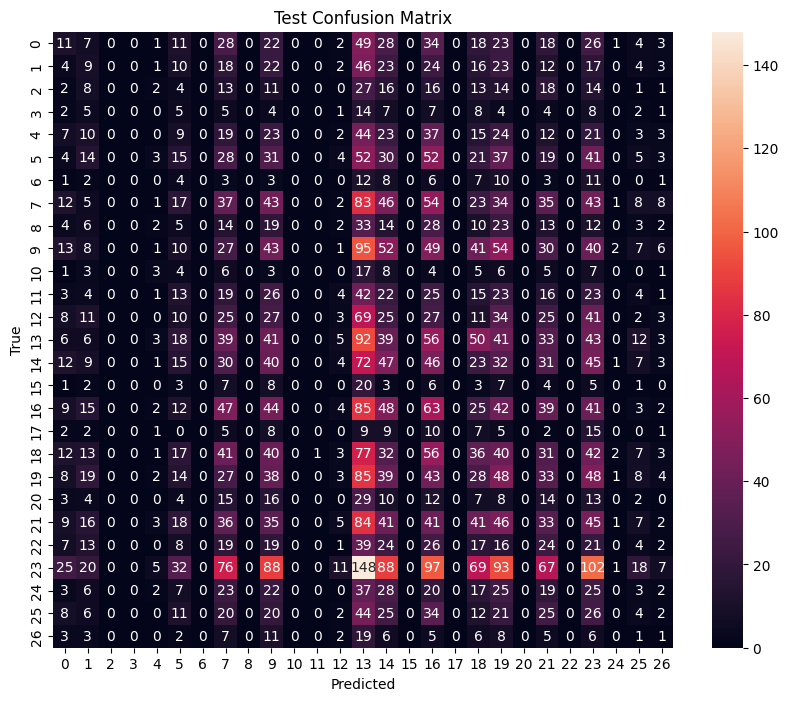

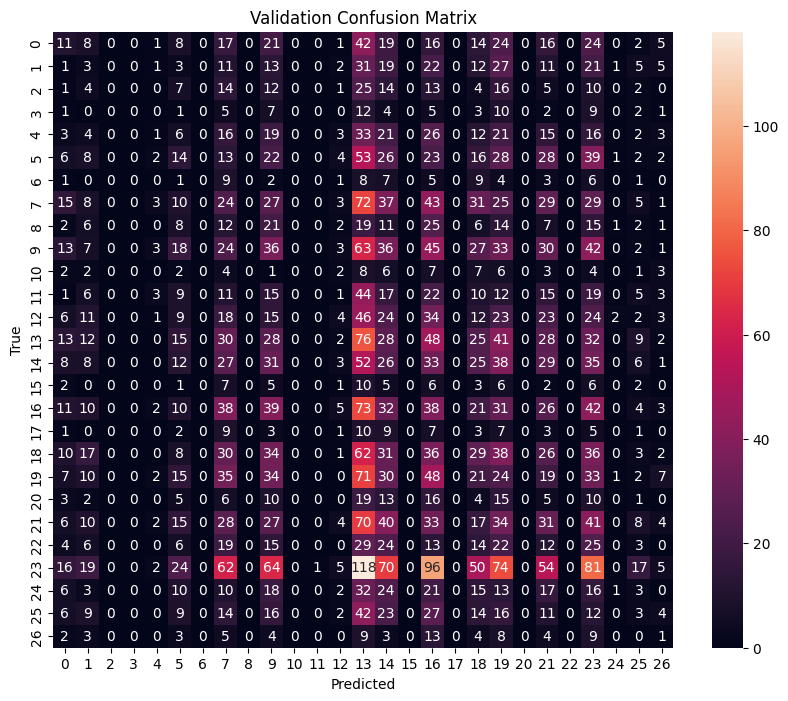

In [ ]:
# Prédictions sur l'ensemble de test
y_pred_test = model.predict(test_generator)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)

# Prédictions sur l'ensemble de validation
y_pred_val = model.predict(val_generator)
y_pred_val_classes = np.argmax(y_pred_val, axis=1)

# Obtenir les vraies étiquettes
y_true_test = test_generator.labels
y_true_val = val_generator.labels

#rapport de classification pour l'ensemble de test
report_test = classification_report(y_true_test, y_pred_test_classes)
print("Test Report")
print(report_test)

#  rapport de classification pour l'ensemble de validation
report_val = classification_report(y_true_val, y_pred_val_classes)
print("Validation Report")
print(report_val)

# matrice de confusion pour l'ensemble de test
confusion_mtx_test = confusion_matrix(y_true_test, y_pred_test_classes)

#  matrice de confusion pour l'ensemble de validation
confusion_mtx_val = confusion_matrix(y_true_val, y_pred_val_classes)

#  la matrice de confusion pour l'ensemble de test
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx_test, annot=True, fmt='d')
plt.title("Test Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#la matrice de confusion pour l'ensemble de validation
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx_val, annot=True, fmt='d')
plt.title("Validation Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


### *Classsification des images avec un CNN Resnet152 de Keras*


In [ ]:
df=pd.read_csv(os.path.join(CSV_FILE_DIR, "df_avec_traduction.csv"))
df.head(2)

designation description   productid  \
0  Olivia: Personalisiertes Notizbuch / 150 Seite...         NaN  3804725264   
1  Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...         NaN   436067568   

      imageid                                         image_path  prdtypecode  \
0  1263597046  /content/drive/Shareddrives/ds_nov22_cnt_rakut...           10   
1  1008141237  /content/drive/Shareddrives/ds_nov22_cnt_rakut...         2280   

                        Labels  \
0             Livres occasions   
1  Archives journaux et presse   

                                     design_describe  \
0  Olivia: Personalisiertes Notizbuch / 150 Seite...   
1  Journal Des Arts (Le) N 133 Du 28/09/2001 - L'...   

                                      designe_decrit  
0  Olivia : Carnet personnalisé / 150 pages / Dot...  
1  Journal Des Arts (Le) N 133 Du 28/09/2001 - L'...

In [ ]:
df['image_name'] = 'image_' + df['imageid'].map(str) + '_product_' + df['productid'].map(str) + '.jpg'
print(df['image_name'].loc[0])

image_1263597046_product_3804725264.jpg


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df[['image_path','Labels']], df.Labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 42)
X_train

image_path  \
14693  /content/drive/Shareddrives/ds_nov22_cnt_rakut...   
50840  /content/drive/Shareddrives/ds_nov22_cnt_rakut...   
80827  /content/drive/Shareddrives/ds_nov22_cnt_rakut...   
42620  /content/drive/Shareddrives/ds_nov22_cnt_rakut...   
76423  /content/drive/Shareddrives/ds_nov22_cnt_rakut...   
...                                                  ...   
61047  /content/drive/Shareddrives/ds_nov22_cnt_rakut...   
26978  /content/drive/Shareddrives/ds_nov22_cnt_rakut...   
39433  /content/drive/Shareddrives/ds_nov22_cnt_rakut...   
33251  /content/drive/Shareddrives/ds_nov22_cnt_rakut...   
71607  /content/drive/Shareddrives/ds_nov22_cnt_rakut...   

                            Labels  
14693                    Papeterie  
50840                    Papeterie  
80827      Eclairage et décoration  
42620  Archives journaux et presse  
76423                    Papeterie  
...                            ...  
61047           Mobilier intérieur  
26978                       Jouets  
39433                 Alimentation  
33251      Eclairage et décoration  
71607              Jeux de société  

[61138 rows x 2 columns]

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization

#from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping,  ModelCheckpoint

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet import ResNet152, preprocess_input

In [ ]:
img_width=256; img_height=256
batch_size=8

In [ ]:
train_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=30,
                                   zoom_range=0.4,
                                   horizontal_flip=True
                                   )

val_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
test_data_generator= ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
train_generator = train_data_generator.flow_from_dataframe(dataframe=X_train,directory=path, x_col = "image_path", y_col = "Labels",
                                                              batch_size=batch_size,
                                                              class_mode='sparse',
                                                              target_size=(img_height, img_width))

val_generator = val_data_generator.flow_from_dataframe(dataframe=X_val,directory=path, x_col = "image_path", y_col = "Labels",
                                                              batch_size=batch_size,
                                                              class_mode='sparse',
                                                              target_size=(img_height, img_width))

test_generator = test_data_generator.flow_from_dataframe(dataframe=X_test,directory=path, x_col = "image_path", y_col = "Labels",
                                                              batch_size=batch_size,
                                                              class_mode='sparse',
                                                              target_size=(img_height, img_width))

Found 61138 validated image filenames belonging to 27 classes.
Found 6794 validated image filenames belonging to 27 classes.
Found 16984 validated image filenames belonging to 27 classes.


In [ ]:
#callbacks = EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')
#best_model_file = '.../resnet152_drop_batch_best_weights_256.h5'
#best_model = ModelCheckpoint(best_model_file, monitor='val_acc', verbose = 1,
_best_only = True)

In [ ]:
resnet152_base = ResNet152(include_top=False, weights='imagenet',
                          input_tensor=None, input_shape=(img_width, img_height,3))

234698864/234698864 [==============================] - 1s 0us/step


In [ ]:
print('Adding new layers...')
output = resnet152_base.get_layer(index = -1).output
output = Flatten()(output)
# let's add a fully-connected layer
output = Dense(1024,activation = "relu")(output)
output = BatchNormalization()(output)
output = Dropout(0.2)(output)
output = Dense(1024,activation = "relu")(output)
output = BatchNormalization()(output)
output = Dropout(0.2)(output)
output = Dense(27, activation='softmax')(output)
print('New layers added!')

Adding new layers...
New layers added!


In [ ]:
resnet152_model = Model(resnet152_base.input, output)
for layer in resnet152_model.layers[:-7]:
    layer.trainable = False

resnet152_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
#opt = tf.keras.optimizers.Adam(lr = 0.0001)
resnet152_model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics =['accuracy'])

In [ ]:
#resnet152_model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics =['accuracy'])

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 7, verbose = 1)
rd_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor = np.sqrt(0.1), patience= 3, verbose = 1, min_lr = 5e-8)

In [ ]:
history = resnet152_model.fit(train_generator, epochs= 30, validation_data= val_generator,steps_per_epoch=100,
                validation_steps=50, workers=-1, callbacks =[rd_lr,es])


Epoch 1/30
100/100 [==============================] - 386s 4s/step - loss: 3.7149 - accuracy: 0.2175 - val_loss: 4.6145 - val_accuracy: 0.3100 - lr: 0.0010
Epoch 2/30
100/100 [==============================] - 355s 4s/step - loss: 3.1463 - accuracy: 0.2862 - val_loss: 3.4954 - val_accuracy: 0.3375 - lr: 0.0010
Epoch 3/30
100/100 [==============================] - 346s 3s/step - loss: 2.8723 - accuracy: 0.3137 - val_loss: 2.9113 - val_accuracy: 0.3700 - lr: 0.0010
Epoch 4/30
100/100 [==============================] - 341s 3s/step - loss: 2.9023 - accuracy: 0.3063 - val_loss: 2.7266 - val_accuracy: 0.4250 - lr: 0.0010
Epoch 5/30
100/100 [==============================] - 330s 3s/step - loss: 2.6896 - accuracy: 0.3413 - val_loss: 2.5554 - val_accuracy: 0.3775 - lr: 0.0010
Epoch 6/30
100/100 [==============================] - 326s 3s/step - loss: 2.5730 - accuracy: 0.3475 - val_loss: 2.5825 - val_accuracy: 0.4225 - lr: 0.0010
Epoch 7/30
100/100 [==============================] - 303s 3s/st

In [ ]:

#resnet152_model.save(os.path.join(CSV_FILE_DIR,'Saliou/resnet152_model.h5'))
resnet152_model_save_path = os.path.join(DRIVE_PATH, "Saliou/resnet152_model.h51")  # ou un autre chemin de votre choix
resnet152_model.save(resnet152_model_save_path)
#resnet152_model.save_weights(os.path.join(CSV_FILE_DIR,'Saliou/resnet152_weights.h5'))

In [ ]:
from tensorflow.keras.models import load_model

# Charger le modèle
resnet152_model= load_model( os.path.join(DRIVE_PATH, "Saliou/resnet152_model.h51"))

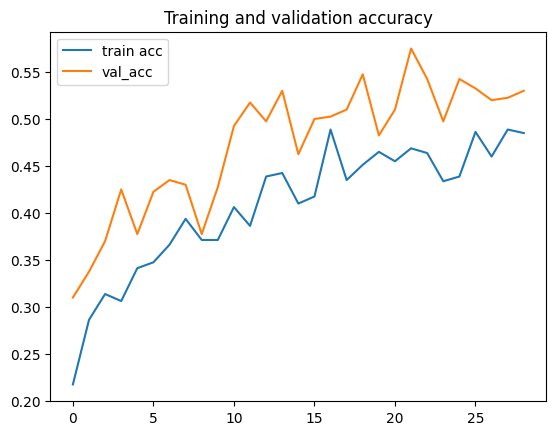

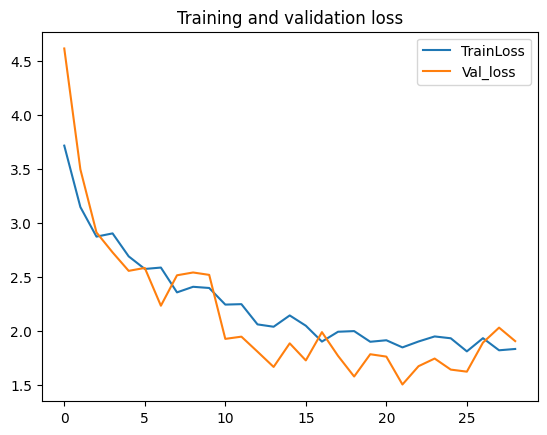

In [ ]:
# %% Check Plots
acc= history.history['accuracy']
val_acc= history.history['val_accuracy']
loss= history.history['loss']
val_loss= history.history['val_loss']

epochs= range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot( epochs, acc, label = 'train acc' )
plt.plot( epochs, val_acc, label = 'val_acc' )
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig('Accuracy Graph Tuned')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot( epochs,     loss, label = 'TrainLoss' )
plt.plot( epochs, val_loss, label = 'Val_loss' )
plt.title('Training and validation loss'   )
plt.savefig('Loss Graph Tuned')
plt.legend()

plt.show()

In [ ]:
filenames = test_generator.filenames
nb_samples = len(filenames)

predict = resnet152_model.predict(test_generator,steps = nb_samples)
predictions = predict.argmax(axis = 1)
true_labels = test_generator.classes

 2123/16984 [==>...........................] - ETA: 9:44:00

16984/16984 [==============================] - 5007s 295ms/step


In [ ]:
import itertools
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):


    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(30, 20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

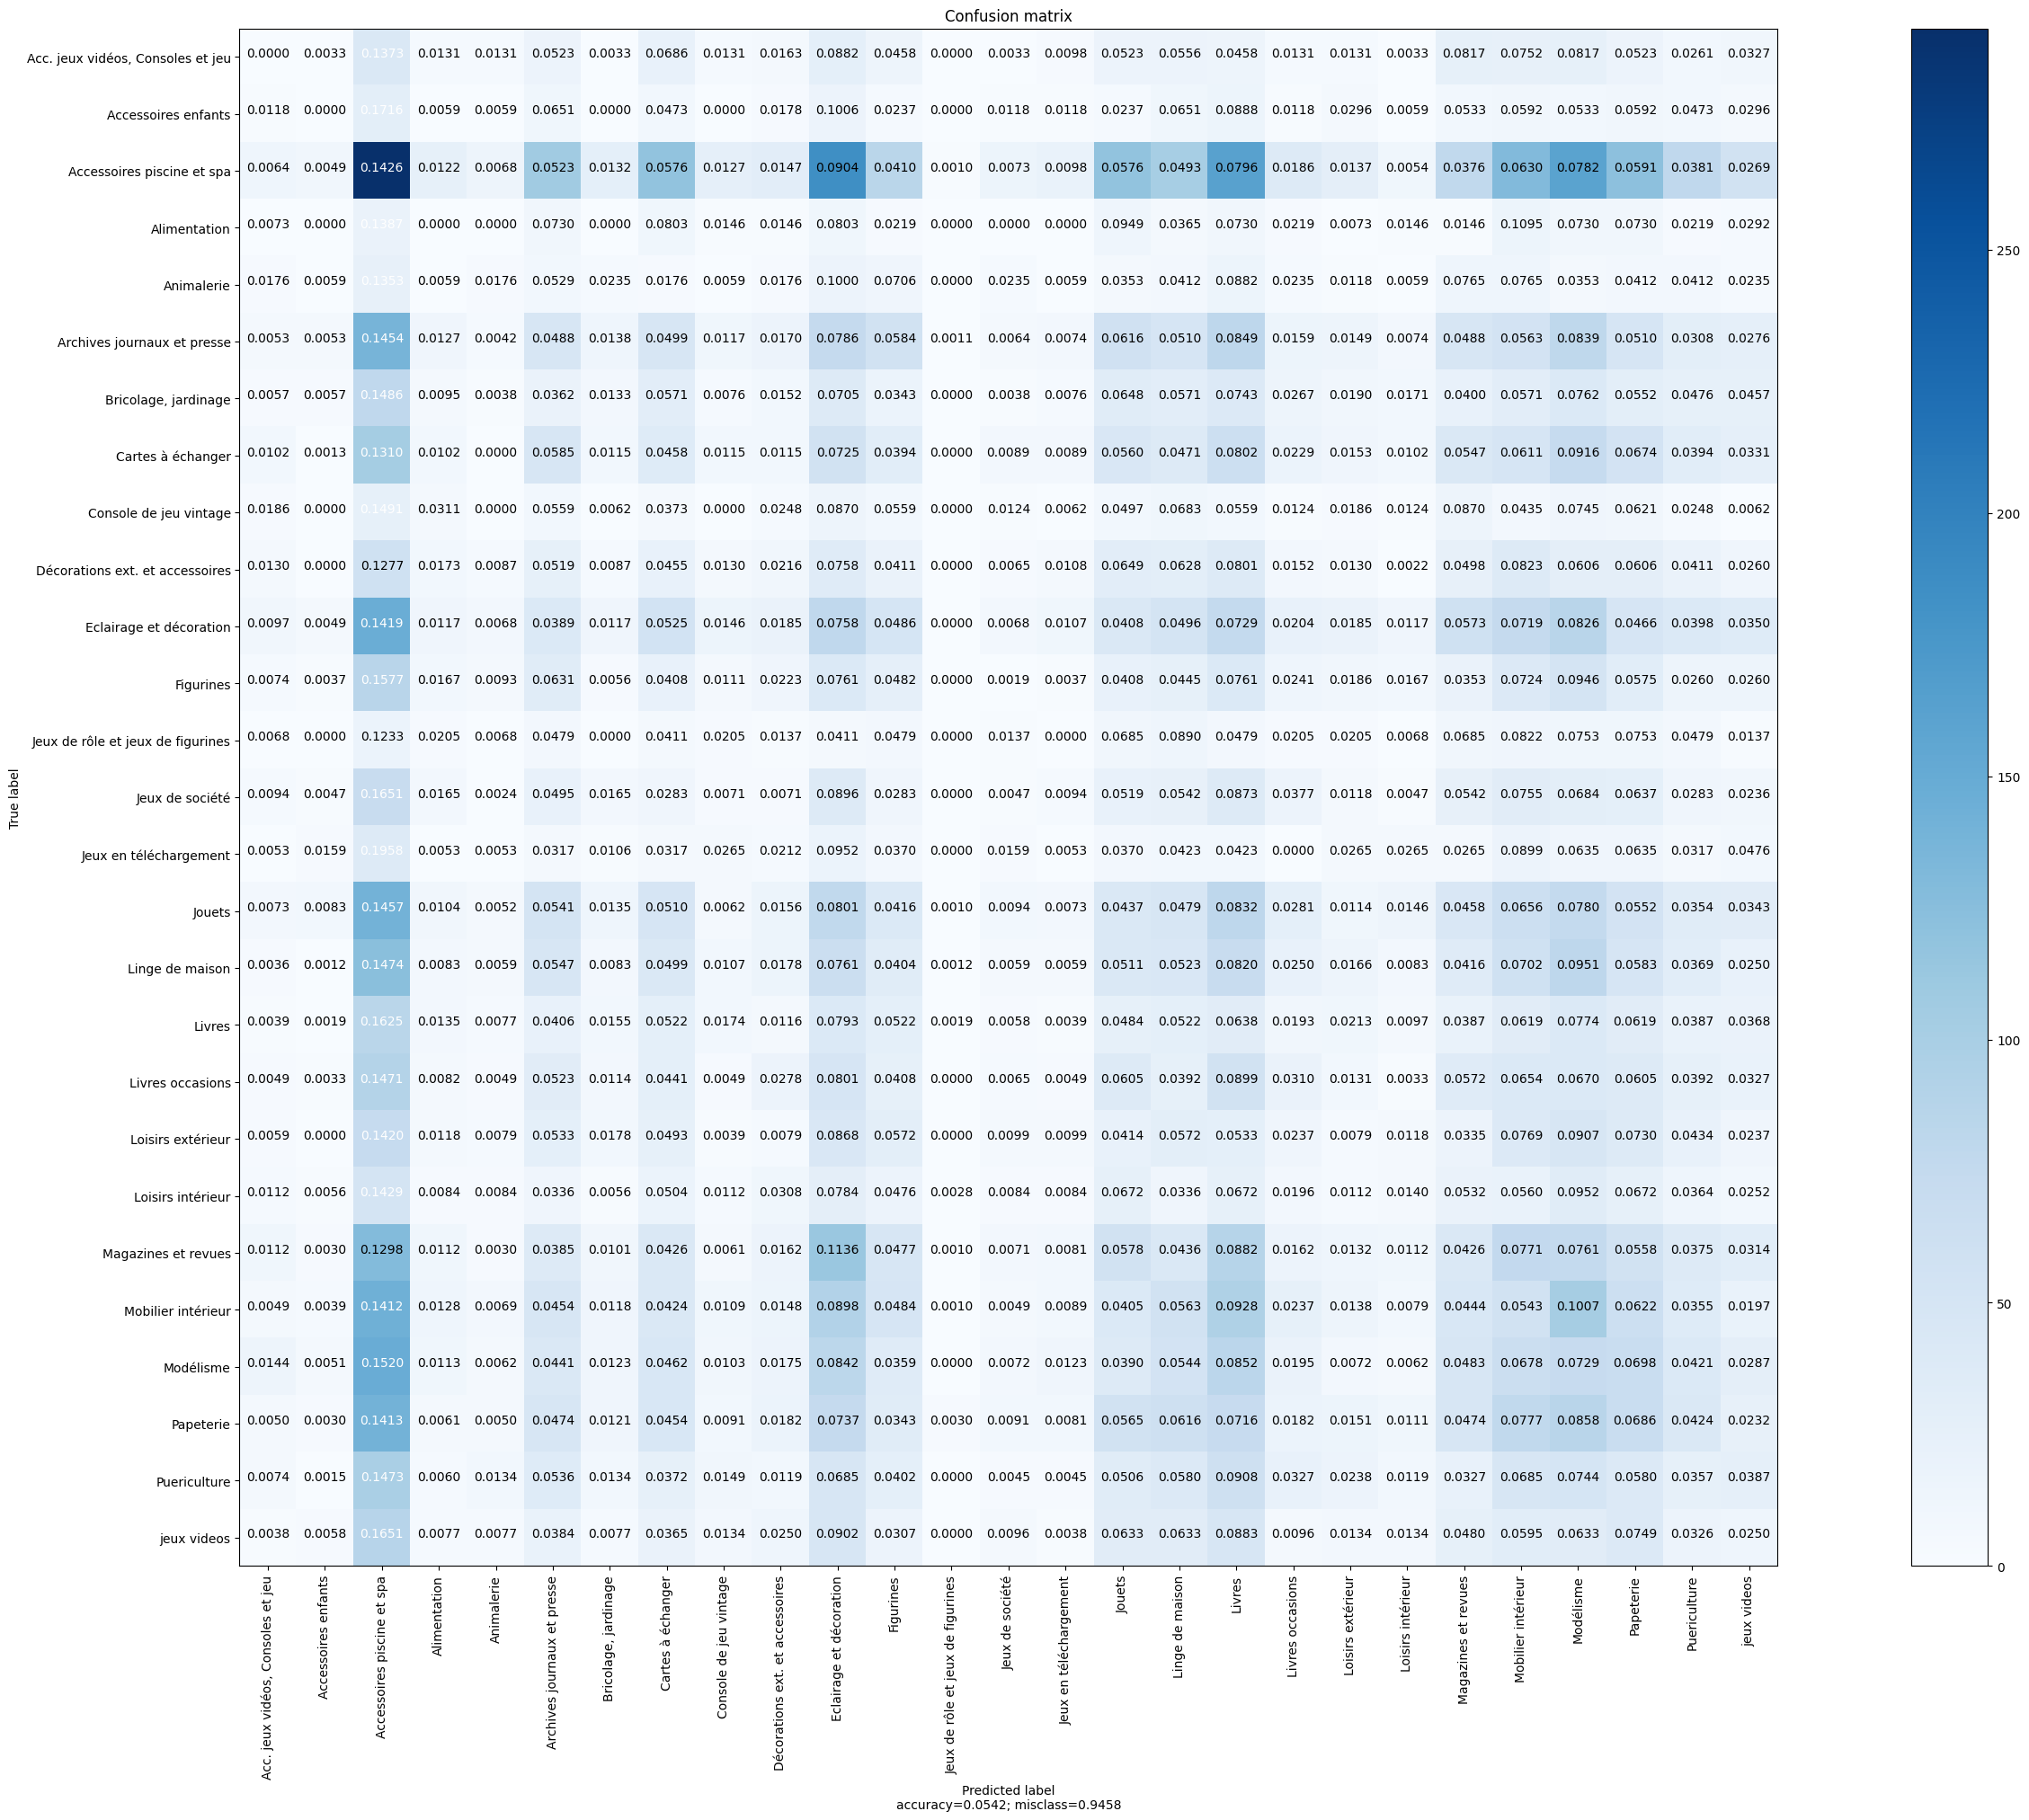

In [ ]:
cm = sklearn.metrics.confusion_matrix(true_labels, predictions)
target_names =train_generator.class_indices
plot_confusion_matrix(cm,target_names)

In [ ]:
test_score = resnet152_model.evaluate_generator(test_generator)
print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100))
print("[INFO] Loss: ",test_score[0])

<ipython-input-27-de3132213c5f>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_score = resnet152_model.evaluate_generator(test_generator)


[INFO] accuracy: 52.08%
[INFO] Loss:  1.6749074459075928


In [ ]:
val_score = resnet152_model.evaluate_generator(val_generator)
print("[INFO] accuracy: {:.2f}%".format(val_score[1] * 100))
print("[INFO] Loss: ",val_score[0])

<ipython-input-28-6bfab66f3680>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  val_score = resnet152_model.evaluate_generator(val_generator)


[INFO] accuracy: 52.21%
[INFO] Loss:  1.7216464281082153


In [ ]:
train_score = resnet152_model.evaluate_generator(train_generator)
print("[INFO] accuracy: {:.2f}%".format(train_score[1] * 100))
print("[INFO] Loss: ",train_score[0])

<ipython-input-29-3584705d2e99>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  train_score = resnet152_model.evaluate_generator(train_generator)


[INFO] accuracy: 52.96%
[INFO] Loss:  1.714401125907898
